<a href="https://colab.research.google.com/github/andreabazerla/real-estate/blob/main/Housing_Price_Prediction_in_Milan_(Italy)_through_Deep_Learning_via_immobiliare_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Housing Price Prediction in Milan (Italy) through Deep Learning via immobiliare.it**

* In **2020** there was a break in **Real Estate Market** because of by **Covid-19** emergency. This crisis caused *price freeze*, *dawnward trading* and *instability*.

* From April 2020 to October in Italy **-0.4% of prices**, **-8.5% in Sardinia** after summer for few turists and **in Milan -2.2%** to then go up again of **+0.5%**.

* Real Estate sales fell of **-19.5%**, specially in Milan with a collapse of **-12%**.

* People paid more attention to green like *private gardens*, or balconies; to large surface in province houses, but in center of cities they search small houses for one person; to quality of services nearby and much more to *countryside* than to traffic *old towns*.

* **Challenge**: predict houses prices in Milan through Deep Learning in this period of instability.

* This project was created by **Andrea Bazerla** in 2021 for *Deep Learning* exam at **University of Ferrara**. It is licensed under MIT License, hosted in [GitHub](https://github.com/andreabazerla/real-estate) and described in [Medium](https://medium.com/@andreabazerla).

## Settings

Initial section to set some settings, import generic libraries useful for whole code and global scripts.

In [101]:
# Generic libraries import

from google.colab import files
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Pandas display options to show all rows and columns of Dataframes

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
def get_timestamp() -> str:
  '''Methods to get current timestamp as a string'''

  return str(int(time.time()))

In [4]:
# ATTENTION: global costants to start processes inside code

URL_SCRAPING = False
ADS_SCRAPING = False

## Web Scraping

What is **Web Scraping**? It is a technique to extract data from a website automatically via HTTPS.

The receiver of data is not an end-user, but a "software". 

Stages of the process: fetching() -> extracting() -> parsing() -> cleaning() -> storing()

In [ ]:
# Import libraries useful for Web Scraping

import requests
import logging
from enum import Enum 
from random import uniform
from bs4 import BeautifulSoup
import urllib.parse

In [ ]:
# Support Enums to build the scraping URL

class Contract(Enum):
  '''Type of contract'''

  SALE = 'vendita'
  RENT = 'affitto'

class Area(Enum):
  '''Search area like a city'''

  ROME = 'roma'
  MILAN = 'milano'
  VENICE = 'venezia'
  TURIN = 'torino'
  NAPLES = 'napoli'

class Criterion(Enum):
  '''Search criterion'''

  RELEVANCE = 'rilevanza'
  PRICE = 'prezzo'

class Sort(Enum):
  '''Sort type of search results'''

  DESC = 'desc'
  ASC = 'asc'

In [ ]:
# Method to build scraping URL 

def build_scraping_url(website, contract, area, criterion=Criterion.RELEVANCE.value, sort=Sort.DESC):
  '''Method to build scraping URL'''

  vars = { 'criterio': criterion }

  if criterion != Criterion.RELEVANCE.value:
    vars['sort'] = sort

  url = website + '/' + contract + '/' + area + '/?' + urllib.parse.urlencode(vars)
  return url

In [ ]:
# Scraping URL parameters

website = 'https://www.immobiliare.it'
contract = Contract.SALE.value + '-case'
area = Area.MILAN.value
criterion = Criterion.RELEVANCE.value
sort = Sort.DESC.value

url = build_scraping_url(website, contract, area, criterion, sort)

In [ ]:
print(url)

In [ ]:
# Method to sleep between HTTP requests

sleep_min = 1
sleep_max = 2

def sleep():
  '''Default method to sleep between HTTP requests

  It returns uniform random time to sleep between sleep_min and sleep_max variables.
  '''

  time.sleep(uniform(sleep_min, sleep_max))

### Ads URL Scraping

In this section Web Scraping is closed to ad URLs.

In [ ]:
def get_last_page(url):
  '''Method that returns the last page number of scraping search'''

  try:
    response = requests.get(url)
    beautiful_soup = BeautifulSoup(response.content, 'html.parser')
  
    ul_pagination = beautiful_soup.find('ul', class_ = 'pagination pagination__number')
    li_list = ul_pagination.find_all('li')
    last_page = int(li_list[-1].get_text().strip())
  
    return last_page
  
  except requests.exceptions.RequestException as e:
    raise SystemExit(e)

In [ ]:
def get_url_list(url, first_page, last_page):
  '''Method that return an ads url list between firts_page and last_page range.
  
  As you can see, between requests there's a sleep to avoid to break target server.
  
  '''

  url_list = []
  page_dropped_list = []
    
  for page in tqdm(range(first_page, last_page + 1)):
    if (page > 1):
      url = url + '&pag=' + str(page)
    
    try:
      response = requests.get(url)
      beautiful_soup = BeautifulSoup(response.content, 'html.parser')
    
      ads_list = beautiful_soup.find('ul', class_ = 'annunci-list')
      ad_item_list = ads_list.find_all('div', class_ = 'listing-item_body--content')
      for ad_item in ad_item_list:
        a_list = ad_item.find_all('a')
        for a in a_list:
          url_list.append(a['href'])
    
    except Exception as e:
      logging.exception(e)
      page_dropped_list.append(page)      
      pass
 
    sleep()

  if page_dropped_list:
    print(page_dropped_list)
  
  return url_list

In [ ]:
# Define first_page and last_page of Web Scraping

first_page = 1
last_page = get_last_page(url)

In [ ]:
# Start ad URLs Web Scraping (only if WEB_SCRAPING is True)

if URL_SCRAPING:
  url_list = get_url_list(url, first_page, last_page)

In [ ]:
# Create a Dataframe for ad URLs with Pandas 

df_url = pd.DataFrame({'url' : list(url_list)})

df_url['id'] = range(1, len(df_url) + 1)
df_url.set_index('id', inplace=True)

In [ ]:
display(df_url.head(10))

In [ ]:
csv_url = 'url_' + str(first_page) + '_' + str(last_page) + '_' + get_timestamp() + '.csv'
df_url.to_csv(csv_url)
files.download(csv_url)

### Ads Scraping 

In [ ]:
import os

In [ ]:
def get_ad_title(soup):
  '''Method that returns ad title'''

  titleBlock__title = soup.find('span', class_ = 'im-titleBlock__title')
  if titleBlock__title is not None:
    return titleBlock__title.get_text()
  else:
    return ''

In [ ]:
def get_ad_price(soup):
  '''Method that returns ad price'''

  mainFeatures__price = soup.find_all('li', class_ = 'im-mainFeatures__price')
  if mainFeatures__price:
    return mainFeatures__price[0].get_text().replace('\n', '').strip()
  else:
    return ''

In [ ]:
def get_ad_main_features(soup):
  '''Method that returns ad main features'''

  main_features = {}
  
  mainFeatures = soup.find('div', class_ = 'im-mainFeatures')
  
  li_list = mainFeatures.find_all('li')
  for li in li_list[1:]:
    value = li.find('span', class_="im-mainFeatures__value").get_text().replace('\n', '').strip()
    label = li.find('span', class_="im-mainFeatures__label").get_text().replace('\n', '').strip()
    
    # If data labels are plural, convert them to singular form
    if (label == 'bagno' or label == 'bagni'):
      label = 'bagni'
    
    if (label == 'locale' or label == 'locali'):
      label = 'locali'
    
    main_features[label] = value
  
  return main_features

In [ ]:
def get_ad_description(soup):
  '''Method that returns ad description'''

  description__text = soup.find('div', class_ = 'im-description__text')
  if description__text is not None:
    return description__text.get_text()
  else:
    return ''

In [ ]:
def get_ad_locations(soup):
  '''Method that returns ad locations like area, district and address if not empty'''
  
  # Legacy code turnaround
  titleBlock__link = soup.find('a', class_ = 'im-titleBlock__link')
  if titleBlock__link is None:
    titleBlock__link = soup.find('h1', class_ = 'im-titleBlock__content')

  location = titleBlock__link.find_all('span', class_ = 'im-location')
  
  try:
    area = location[0].get_text().strip()
  except IndexError:
    area = ''
  
  try:
    district = location[1].get_text().strip()
  except IndexError:
    district = ''

  try:
    address = location[2].get_text().strip()
  except IndexError:
    address = ''

  return [area, district, address]

In [ ]:
def get_ad_feature_list(soup):
  '''Method that returns ad feature list in tag form as a set'''

  features = {}
  
  features__list = soup.find_all("dl", class_ = "im-features__list")
  
  for feature_block in features__list:
    feature__title_list = feature_block.find_all('dt', class_ = 'im-features__title')
  
    for feature__title in feature__title_list:
      feature__value = feature__title.findNext('dd')
  
      if ('im-features__tagContainer' in feature__value.get('class')):
        features__tag_array = []

        features__tag_list = soup.find_all('span', class_ = 'im-features__tag')
        for feature__tag in features__tag_list:
          features__tag_array.append(feature__tag.get_text().strip())
  
        features__tag_list_string = ','.join(features__tag_array)
        feature__value_2 = features__tag_list_string
  
      else:
        feature__value_2 = feature__value.get_text().strip()
  
      feature__title_2 = feature__title.get_text().strip()
      features['f_' + feature__title_2] = feature__value_2
  
  return features

In [ ]:
def get_ad_single(url, soup):

  ads_list = []

  ad_data = {}

  ad_data['url'] = url

  # Get ad title
  title = get_ad_title(soup);
  ad_data['titolo'] = title

  # Get ad price
  price = get_ad_price(soup);
  ad_data['prezzo'] = price

  # Get ad main features
  main_features = get_ad_main_features(soup)
  if main_features:
    ad_data.update(main_features)

  # Get ad description
  description = get_ad_description(soup);
  ad_data['descrizione'] = description

  # Get ad area, district and address
  area, district, address = get_ad_locations(soup)
  ad_data['area'] = area
  ad_data['quartiere'] = district
  ad_data['indirizzo'] = address

  # Get ad tag features
  feature_list = get_ad_feature_list(soup)
  if feature_list:
    ad_data.update(feature_list)

  # Add to ad an hashcode based on its data
  ad_data['hashcode'] = hash(frozenset(ad_data.items()))

  ads_list.append(ad_data)

  return ads_list

In [ ]:
def get_ad_multi(url, soup):
  ads_list = []

  title = get_ad_title(soup)

  area, district, address = get_ad_locations(soup)

  main_features = get_ad_main_features(soup)

  description = get_ad_description(soup)

  feature_list = get_ad_feature_list(soup)

  properties__list = soup.find('ul', class_ = 'im-properties__list')
  properties__item_list = properties__list.find_all('li', class_ = 'im-properties__item')
  for properties__item in properties__item_list:
    ad_data = {}

    ad_data['url'] = url

    ad_data['titolo'] = title

    ad_data['area'] = area
    ad_data['quartiere'] = district
    ad_data['indirizzo'] = address
    
    price = get_ad_price(properties__item)
    ad_data['prezzo'] = price

    ad_data['descrizione'] = description

    sub_features = get_ad_main_features(properties__item)
    if sub_features:
      ad_data.update(sub_features)

    title_2 = properties__item.find('p', class_ = 'nd-mediaObject__title')
    if title_2 is not None:
      ad_data['titolo_2'] = title_2.get_text().strip()

    description_2 = properties__item.find('div', class_ = 'im-properties__content')
    if description_2 is not None:
      ad_data['descrizione_2'] = description_2.get_text()

    if feature_list:
      ad_data.update(feature_list)

    ad_data['hashcode'] = hash(frozenset(ad_data.items()))

    ads_list.append(ad_data)

  return ads_list

In [ ]:
def get_ad(url):

  ads_list = []
  url_dropped_list = []

  try:
    response = requests.get(url)
    if response:
      soup = BeautifulSoup(response.content, "html.parser")

      if 'p-' in url:
        ad_data = get_ad_multi(url, soup)
      else:
        ad_data = get_ad_single(url, soup)

      ads_list.extend(ad_data)

  except Exception as e:
    logging.exception(e)
    url_dropped_list.append(url)
    pass

  return [ads_list, url_dropped_list]

In [ ]:
# Read ads URL from CSV file

df_url = pd.read_csv('url_1_639_1620401663.csv')
url_list = df_url['url'].to_list()

In [ ]:
if ADS_SCRAPING:
  df_ads = pd.DataFrame()

  first_ad = 0

  # Set last_ad to first_ad + 500 
  last_ad = 5
  #last_ad = len(url_list)
  
  ads_csv = 'ads_' + str(first_ad + 1) + '_' + str(last_ad) + '_' + get_timestamp() + '.csv'

  ads_list = []
  url_dropped_list = []
  for i in tqdm(range(first_ad, last_ad)):

    ad_data = get_ad(url_list[i])

    if ad_data[1]:
      url_dropped_list.extend(ad_data[1])

    for ad in ad_data[0]:
      ads_list.append(ad)
    
    sleep()

In [ ]:
print(url_dropped_list)

In [ ]:
df_ads = pd.DataFrame(ads_list)

df_ads.fillna('', inplace=True)

df_ads['id'] = range(1, len(df_ads) + 1)
df_ads.set_index('id', inplace=True)

In [ ]:
display(df_ads)

In [ ]:
df_ads.to_csv(ads_csv)

In [ ]:
files.download(ads_csv)

In [ ]:
ads_folder = 'ads'
file_list = os.listdir(ads_folder)
ads_files = [file for file in file_list if file.startswith('Ads')]
ads_files.sort()

df_files = [None] * len(ads_files)
for idx, file in enumerate(ads_files):
  df_files[idx] = pd.read_csv(os.path.join(ads_folder, file))

df_final = pd.concat(df_files).drop_duplicates().reset_index(drop=True)

ads_csv_final = 'Ads' + '_' + get_timestamp() + '.csv'
df_final.to_csv(ads_csv_final, index=False)

In [ ]:
files.download(ads_csv_final)

## Data Cleaning

* Data Cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

* In this section from raw real estate data just web scraped in the previous section, you'll remove multiple real estate ads with few features, auction real estates, without price or other essential features, useless column, etc. 

* Extract important data from string via regular expressions

* Conversion of prices in clean integers without decimal, string in lower case, list of features in one-encoding columns, etc.


In [ ]:
# Import Data Cleaning libraries

import re

from sklearn.preprocessing import MultiLabelBinarizer

from scipy.stats import zscore

In [ ]:
files.upload()

In [ ]:
# Read Ads from CSV file

csv_ads = 'ads_1617101603.csv'
df_ads = pd.read_csv(csv_ads, dtype=str)

In [ ]:
print(df_ads.info())
display(df_ads.describe().transpose())
display(df_ads.head(10).T)

In [ ]:
# Create an ID as index
df_ads['id'] = range(1, len(df_ads) + 1)
df_ads.set_index('id', inplace = True)

In [ ]:
# Remove multiple Ads 
df_ads = df_ads[~df_ads['url'].str.contains('p-')]

In [ ]:
# Remove rows if the following columns are not empty
index_names = df_ads[
  (df_ads['f_offerta minima'].notnull())
  | (df_ads['f_rialzo minimo'].notnull())
  | (df_ads['f_Spesa prenota debito'].notnull())
  | (df_ads['f_Contributo non dovuto'].notnull())
  | (df_ads['f_Tribunale'].notnull())
  | (df_ads['f_termine presentazione'].notnull())
  | (df_ads['f_lotto numero'].notnull())
  | (df_ads['f_Deposito cauzionale'].notnull())
  | (df_ads['f_luogo vendita'].notnull())
  | (df_ads['f_Luogo presentazione'].notnull())
  | (df_ads['f_categoria'].notnull())
  | (df_ads['f_Procedura'].notnull())
  | (df_ads['f_numero procedura'].notnull())
  | (df_ads['f_Delegato'].notnull())
  | (df_ads['f_Giudice'].notnull())
  | (df_ads['f_Custode'].notnull())
  | (df_ads['f_Dati catastali'].notnull())
  | (df_ads['f_Rialzo minimo in caso di gara'].notnull())
  | (df_ads['f_Motivo esenzione'].notnull())
  | (df_ads['f_note'].notnull())
  | (df_ads['f_Rito'].notnull())
  | (df_ads['f_Curatore'].notnull())
  | (df_ads['f_Altri dati catastali'].notnull())
  | (df_ads['f_Deposito conto spese'].notnull())
  | (df_ads['f_Cauzione e spese'].notnull())
  | (df_ads['f_Referente'].notnull())
  | (df_ads['f_valore perizia'].notnull())
  | (df_ads['f_Delegato alla vendita'].notnull())
].index

df_ads = df_ads.drop(index_names)

In [ ]:
# Remove useless columns
columns_useless = [
  'url',
  'area',
  'descrizione',
  'titolo_2',
  'descrizione_2',
  'f_superficie',
  'f_prezzo',
  'f_riferimento e Data annuncio',
  'f_immobile garantito',
  'f_contratto',
  'f_unità',
  'f_Data di inizio lavori e di consegna prevista',
  'f_Indice prest. energetica rinnovabile',
  'f_Prestazione energetica del fabbricato',
  'f_disponibilità',
  'f_certificazione energetica',
  'f_numero immobili',
  'f_aggiornato il',
  'hashcode',
  'data vendita',
  'f_Tipo vendita',
  'f_data vendita',
  'f_offerta minima',
  'f_rialzo minimo',
  'f_Spesa prenota debito',
  'f_Contributo non dovuto',
  'f_Tribunale',
  'f_termine presentazione',
  'f_lotto numero',
  'f_Deposito cauzionale',
  'f_luogo vendita',
  'f_Luogo presentazione',
  'f_categoria',
  'f_Procedura',
  'f_numero procedura',
  'f_Delegato',
  'f_Giudice',
  'f_Custode',
  'f_Dati catastali',
  'f_Rialzo minimo in caso di gara',
  'f_Motivo esenzione',
  'f_note',
  'f_Rito',
  'f_Curatore',
  'f_Altri dati catastali',
  'f_Deposito conto spese',
  'f_Cauzione e spese',
  'f_Referente',
  'f_valore perizia',
  'f_Delegato alla vendita'
]

df_ads = df_ads.drop(columns_useless, axis=1)

In [ ]:
# Remove auction ads that contains string 'da' in column 'prezzo'
df_ads = df_ads[~df_ads['prezzo'].str.contains('da', na=False)]

In [ ]:
# Remove rows if their columns value is not popular
columns_unique_treshold = df_ads[['quartiere']]
df_ads = df_ads[columns_unique_treshold.replace(columns_unique_treshold.apply(pd.Series.value_counts)).gt(10).all(1)]

columns_unique_treshold_2 = df_ads[['f_stato']]
df_ads = df_ads[columns_unique_treshold_2.replace(columns_unique_treshold_2.apply(pd.Series.value_counts)).gt(10).all(1)]

columns_unique_treshold_3 = df_ads[['f_Tipo proprietà']]
df_ads = df_ads[columns_unique_treshold_3.replace(columns_unique_treshold_3.apply(pd.Series.value_counts)).gt(10).all(1)]

columns_unique_treshold_4 = df_ads[['f_tipologia']]
df_ads = df_ads[columns_unique_treshold_4.replace(columns_unique_treshold_4.apply(pd.Series.value_counts)).gt(10).all(1)]

In [ ]:
# Extract and normalize type and class of proprieties
df_ads = df_ads[df_ads['f_Tipo proprietà'].notna()]
df_ads['c_Tipo proprietà'] = df_ads['f_Tipo proprietà'].str.extract(r"(Intera proprietà|Multiproprietà|Usufrutto|Diritto di superficie|Parziale proprietà|Nuda proprietà)", flags = re.IGNORECASE)
df_ads['c_Classe proprietà'] = df_ads['f_Tipo proprietà'].str.extract(r"(classe immobile economica|classe immobile media|classe immobile signorile|immobile di lusso)", flags = re.IGNORECASE)
df_ads['c_Tipo proprietà'] = df_ads['c_Tipo proprietà'].str.lower().str.strip()
df_ads['c_Classe proprietà'] = df_ads['c_Classe proprietà'].str.lower().str.strip()
df_ads = df_ads[df_ads['c_Tipo proprietà'].notna()]
df_ads = df_ads[df_ads['c_Classe proprietà'].notna()]

In [ ]:
# Normalize the following columns string value
df_ads['f_tipologia'] = df_ads['f_tipologia'].str.lower().str.strip()
df_ads = df_ads[df_ads['f_tipologia'].notna()]

In [ ]:
df_ads['quartiere'] = df_ads['quartiere'].str.lower().str.strip()
df_ads = df_ads[df_ads['quartiere'].notna()]

In [ ]:
# Extract and normalize status of pripriety like new, to be restructured, etc.
df_ads = df_ads[df_ads['f_stato'].notna()]
df_ads['c_stato'] = df_ads['f_stato'].str.extract(r"(Da ristrutturare|Nuovo \/ In costruzione|Buono \/ Abitabile|Ottimo \/ Ristrutturato)", flags = re.IGNORECASE)
df_ads['c_stato'] = df_ads['f_stato'].str.lower().str.strip()
df_ads = df_ads[df_ads['c_stato'].notna()]

In [ ]:
df_ads = df_ads[df_ads['f_Efficienza energetica'].notna()]

In [ ]:
# Extract and normalize price of proprieties
df_ads['prezzo'] = df_ads['prezzo'].replace('[\€\.]', '', regex=True).replace(',00', '')
df_ads['prezzo'] = df_ads['prezzo'].str.extract(r'(\d+)')
df_ads = df_ads[df_ads['prezzo'].notna()]
df_ads['prezzo'] = df_ads['prezzo'].astype(int)

In [ ]:
# Remove rows where z-score of proprieties price is astypically grater than 3 and lower than 10'000€
prezzo_filtered = abs(zscore(df_ads['prezzo'])) < 3
df_ads = df_ads[prezzo_filtered]
df_ads = df_ads[df_ads['prezzo'] > 10000]

In [ ]:
# Extract surface area of proprieties
df_ads['superficie'] = df_ads['superficie'].str.extract(r'(\d+)')
df_ads = df_ads[df_ads['superficie'].notna()]
df_ads['superficie'] = df_ads['superficie'].astype(int)

In [ ]:
# Extract number of bathrooms of proprieties
df_ads['bagni'] = df_ads['bagni'].str.extract(r'(1|2|3\+|3)')
df_ads['bagni'] = df_ads['bagni'].fillna('0')
df_ads['bagni'] = df_ads['bagni'].astype(str)

In [ ]:
# Extract number of rooms of proprieties
df_ads['locali'] = df_ads['locali'].str.extract(r"(1|2|3|4|5\+|5)")
df_ads = df_ads[df_ads['locali'].notna()]
df_ads['locali'] = df_ads['locali'].astype(str)

In [ ]:
# Extract number of bedrooms and others rooms of proprieties
df_ads['c_camere da letto'] = df_ads['f_locali'].str.extract(r"(\d\scamer[a,e] da letto)", flags = re.IGNORECASE)
df_ads['c_altri locali'] = df_ads['f_locali'].str.extract(r"(\d\saltr[o,i])", flags = re.IGNORECASE)
df_ads = df_ads[df_ads['c_camere da letto'].notna()]
df_ads = df_ads[df_ads['c_altri locali'].notna()]

# Calculate total number of rooms
df_ads['c_calcolo numero locali'] = df_ads['c_camere da letto'].str.extract(r"(\d)").astype(int) + df_ads['c_altri locali'].str.extract(r"(\d)").astype(int)
df_ads['c_numero totale locali'] = df_ads['locali']

# Proprieties that have number of rooms equals to 5+, replace it with the exact number of them
df_ads.loc[df_ads['c_numero totale locali'] == '5+', 'c_numero totale locali'] = df_ads['c_calcolo numero locali']
df_ads['c_numero totale locali'] = df_ads['c_numero totale locali'].astype(int)

df_ads['c_camere da letto'] = df_ads['c_camere da letto'].str.extract(r"(\d)").astype(int)
df_ads['c_altri locali'] = df_ads['c_altri locali'].str.extract(r"(\d)").astype(int)

df_ads['c_numero totale locali'] = df_ads['c_numero totale locali'].astype(int)

df_ads.drop(['c_calcolo numero locali'], axis=1, inplace=True)

In [ ]:
# Extract and normalize type of 
df_ads['c_tipo cucina'] = df_ads['f_locali'].str.extract(r"(cucina abitabile|cucina a vista|cucina angolo cottura|cucina cucinotto|cucina semi abitabile)", flags = re.IGNORECASE)
df_ads['c_tipo cucina'] = df_ads['c_tipo cucina'].str.lower().str.strip().fillna('')

In [ ]:
# Set if proprieties has a tennis court
df_ads['c_campo da tennis'] = df_ads['f_locali'].str.contains("campo da tennis").astype(int).astype(str)

In [ ]:
# Extract condominium fees and fill with '0' if value is empty
df_ads['f_spese condominio'] = df_ads['f_spese condominio'].str.extract(r'(\d+)')
df_ads['f_spese condominio'] = df_ads['f_spese condominio'].fillna(0)
df_ads['f_spese condominio'] = df_ads['f_spese condominio'].astype(int)

In [ ]:
# Extract floors number and remove rows with it grater than 44
df_ads['f_totale piani edificio'] = df_ads['f_totale piani edificio'].str.extract(r'(\d+)')
df_ads = df_ads[df_ads['f_totale piani edificio'].notna()]
df_ads['f_totale piani edificio'] = df_ads['f_totale piani edificio'].astype(int)
df_ads = df_ads[(df_ads['f_totale piani edificio'] < 44)]

In [ ]:
df_ads = df_ads[df_ads['f_anno di costruzione'].notna()]
df_ads['f_anno di costruzione'] = df_ads['f_anno di costruzione'].astype(float).astype(int)

In [ ]:
# Split propriety features to convert them as a list
df_ads['f_altre caratteristiche'] = df_ads['f_altre caratteristiche'].str.split(',')
df_ads['f_altre caratteristiche'] = df_ads['f_altre caratteristiche'].fillna('')

In [ ]:
# Extract energy efficiency type
df_ads = df_ads[df_ads['f_Efficienza energetica'].notna()]
df_ads['f_Efficienza energetica tipo'] = df_ads['f_Efficienza energetica'].str.extract(r"(^[A-Z][\+]?[\d]?)", flags = re.IGNORECASE)
df_ads['f_Efficienza energetica tipo'] = df_ads['f_Efficienza energetica tipo'].str.upper()
df_ads['f_Efficienza energetica tipo'] = df_ads['f_Efficienza energetica tipo'].str.strip()
df_ads = df_ads[df_ads['f_Efficienza energetica tipo'].notna()]

In [ ]:
# Extract energy efficiency value
df_ads['f_Efficienza energetica valore'] = df_ads['f_Efficienza energetica'].str.extract(r"(\d+[,]?\d+)", flags = re.IGNORECASE)
df_ads['f_Efficienza energetica valore'] = df_ads['f_Efficienza energetica valore'].replace('[\,]', '.', regex=True)
df_ads['f_Efficienza energetica valore'] = df_ads['f_Efficienza energetica valore'].str.strip().astype(float)
df_ads = df_ads[df_ads['f_Efficienza energetica valore'].notna()]

In [ ]:
# Extract propriety address from title through a complex regex with all italian street denominations like bridge, highway, square, etc. and concat with ', milano' string 
regex_address = "((?:alzaia|arco|autostrada|belvedere|calata|calle|cavalcavia|circonvallazione|corso|corte|cortile|discesa|foro|galleria|gradinata|larghetto|largo|litoranea|lungargine|lungofiume|lungolago|lungomare|lungoparco|lungotorrente|molo|parcheggio|passaggio|passeggiata|percorso ciclabile|percorso ciclopedonale|percorso pedonale|piazza|piazzale|piazzetta|pista ciclabile|ponte|raccordo|rampa|ripa|ronco|rotatoria|rotonda|salita|scalinata|scesa|sentiero|slargo|sottopasso|sovrappasso|spiazzo|strada|strada antica|strada comunale|strada consortile|strada nuova|strada panoramica|strada poderale|strada privata|strada provinciale|strada regionale|strada statale|strada vecchia|strada vicinale|stradella|stradello|stradone|tangenziale|traversa|traversa privata|via|via antica|via comunale|via nazionale|via nuova|via panoramica|via privata|via provinciale|via vecchia|viale|vialetto|vico|vico chiuso|vico cieco|vico privato|vicoletto|vicolo|vicolo chiuso|vicolo cieco|vicolo privato|viottolo)\s+[\d]*[\u00c4-\u00e4\u00d6-\u00f6-\u00dc-\u00fc-\u00dfa-zA-Z-'\s\.]*[,\s]*[\d]+[\w-]*)"
df_ads['indirizzo_2'] = df_ads['titolo'].str.extract(regex_address, flags = re.IGNORECASE)
df_ads['indirizzo_2'] = df_ads['indirizzo_2'] + ', milano'
df_ads['indirizzo_2'] = df_ads['indirizzo_2'].str.lower().str.strip()
df_ads['indirizzo_2'] = df_ads['indirizzo_2'].fillna('')

In [ ]:
# Extract number of paking spaces and split in two columns based on their type like internal/external
df_ads['g_garage/box'] = df_ads['f_Posti Auto'].str.extract(r"(\d\sin garage\/box)", flags = re.IGNORECASE)
df_ads['e_all\'esterno'] = df_ads['f_Posti Auto'].str.extract(r"(\d\sall'esterno)", flags = re.IGNORECASE)
df_ads['g_garage/box'] = df_ads['g_garage/box'].str.extract(r'(\d+)')
df_ads['e_all\'esterno'] = df_ads['e_all\'esterno'].str.extract(r'(\d+)')
df_ads['g_garage/box'] = df_ads['g_garage/box'].fillna(0)
df_ads['e_all\'esterno'] = df_ads['e_all\'esterno'].fillna(0)
df_ads['g_garage/box'] = df_ads['g_garage/box'].astype(int)
df_ads['e_all\'esterno'] = df_ads['e_all\'esterno'].astype(int)
df_ads['c_garage number'] = df_ads['g_garage/box'] + df_ads['e_all\'esterno']

In [ ]:
# Set to '1' if there is a lift '0' otherwise
df_ads['f_ascensore'] = df_ads['f_piano'].apply(lambda x: '1' if (pd.notna(x) and 'con ascensore' in x) else '0')

In [ ]:
# Set to '1' if there is an access for disabled people '0' otherwise
df_ads['f_disabili'] = df_ads['f_piano'].apply(lambda x: '1' if (pd.notna(x) and 'con accesso disabili' in x) else '0')

In [ ]:
# Extract air conditioning system like autonomous, centralised, etc.
df_ads['c_Climatizzazione impianto'] = df_ads['f_Climatizzazione'].str.extract(r"(Autonomo|Centralizzato|Predisposizione impianto)", flags = re.IGNORECASE)
df_ads['c_Climatizzazione impianto'] = df_ads['c_Climatizzazione impianto'].str.lower().str.strip().fillna('')

In [ ]:
# Extract air conditioning type like cold, hot, cold/hot
df_ads['c_Climatizzazione tipo'] = df_ads['f_Climatizzazione'].str.extract(r"(freddo/caldo|freddo|caldo)", flags = re.IGNORECASE)
df_ads['c_Climatizzazione tipo'] = df_ads['c_Climatizzazione tipo'].str.lower().str.strip().fillna('')

In [ ]:
# Extract heating system like autonomous or centralised
df_ads['c_riscaldamento impianto'] = df_ads['f_riscaldamento'].str.extract(r"(Centralizzato|Autonomo)", flags = re.IGNORECASE)
df_ads['c_riscaldamento impianto'] = df_ads['c_riscaldamento impianto'].str.lower().str.strip().fillna('')

In [ ]:
# Extract heating type like air, stove, etc.
df_ads['c_riscaldamento tipo'] = df_ads['f_riscaldamento'].str.extract(r"(a pavimento|a radiatori|ad aria|a stufa)", flags = re.IGNORECASE)
df_ads['c_riscaldamento tipo'] = df_ads['c_riscaldamento tipo'].str.lower().str.strip().fillna('')

In [ ]:
# Extract heating supply like gasoline, gas, pellet, etc.
df_ads['c_riscaldamento alimentazione'] = df_ads['f_riscaldamento'].str.extract(r"(alimentato a metano|alimentato a gasolio|alimentato a gas|alimentato a pompa di calore|alimentato a gpl|alimentato a teleriscaldamento|alimentazione elettrica|alimentato a fotovoltaico|alimentato a solare|alimentato a pellet)", flags = re.IGNORECASE)
df_ads['c_riscaldamento alimentazione'] = df_ads['c_riscaldamento alimentazione'].str.lower().str.strip().fillna('')

In [ ]:
# Convert propriety feature list in one-hot encoding columns with string 'c_' as prefixer
mlb = MultiLabelBinarizer()
df_ads = df_ads.join(
  pd.DataFrame(mlb.fit_transform(df_ads.pop('f_altre caratteristiche')),
  columns=mlb.classes_,
  index=df_ads.index).add_prefix('c_'))

In [ ]:
# Convert features columns in string type
feature_columns = [
  'c_Armadio a muro',
  'c_Arredato',
  'c_Balcone',
  'c_Caminetto',
  'c_Cancello elettrico',
  'c_Cantina',
  'c_Esposizione doppia',
  'c_Esposizione esterna',
  'c_Esposizione interna',
  'c_Fibra ottica',
  'c_Giardino comune',
  'c_Giardino privato',
  'c_Idromassaggio',
  'c_Impianto di allarme',
  'c_Impianto tv centralizzato',
  'c_Impianto tv con parabola satellitare',
  'c_Impianto tv singolo',
  'c_Infissi esterni in doppio vetro / PVC',
  'c_Infissi esterni in doppio vetro / legno',
  'c_Infissi esterni in doppio vetro / metallo',
  'c_Infissi esterni in triplo vetro / PVC',
  'c_Infissi esterni in triplo vetro / legno',
  'c_Infissi esterni in triplo vetro / metallo',
  'c_Infissi esterni in vetro / PVC',
  'c_Infissi esterni in vetro / legno',
  'c_Infissi esterni in vetro / metallo',
  'c_Mansarda',
  'c_Parzialmente Arredato',
  'c_Piscina',
  'c_Porta blindata',
  'c_Portiere intera giornata',
  'c_Portiere mezza giornata',
  'c_Reception',
  'c_Solo Cucina Arredata',
  'c_Taverna',
  'c_Terrazza',
  'c_VideoCitofono'
]

df_ads[feature_columns] = df_ads[feature_columns].astype(str)

In [ ]:
# Remove columns not longer useful
df_ads = df_ads.drop('titolo', axis=1)
df_ads = df_ads.drop('indirizzo', axis=1)
df_ads = df_ads.drop('f_locali', axis=1)
df_ads = df_ads.drop('f_piano', axis=1)
df_ads = df_ads.drop('f_Tipo proprietà', axis=1)
df_ads = df_ads.drop('f_tipologia', axis=1)
df_ads = df_ads.drop('f_stato', axis=1)
df_ads = df_ads.drop('f_Climatizzazione', axis=1)
df_ads = df_ads.drop('f_riscaldamento', axis=1)
df_ads = df_ads.drop('f_Posti Auto', axis=1)
df_ads = df_ads.drop('f_Efficienza energetica', axis=1)

In [ ]:
display(df_ads.info())
display(df_ads.describe().transpose())
display(df_ads.head(10).T)

In [ ]:
csv_ads_clean = 'ads_clean_' + get_timestamp() + '.csv'
df_ads.to_csv(csv_ads_clean)
files.download(csv_ads_clean)

## Data Enrichment

* **Data Enrichment** is the process to include third-party data from external sources in an existent databases with new few features to enchance quality for modelling, describing and predicting.

* In this section you'll use **Geocoder** library to convert real estate addresses to geographical coordinates. With these you can calculate then distance between houses and top attractions. 

* In that case we only consider **Duomo** of top attractions placed in coordinates 45°27'50.8"N 9°11'30.8"E, that is in the center of city because Milan is a concentric city so it could be enough for our analysis.

### Geocoder

In [ ]:
import math

from geopy import distance
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
files.upload()

In [ ]:
# Import ads clean CSV file

csv_ads_clean = 'ads_clean_1619166011.csv'
df_ads_geo = pd.read_csv(csv_ads_clean)

In [ ]:
geolocator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

tqdm.pandas()

df_ads_geo = df_ads.copy()

df_ads_geo['geocode_address'] = df_ads_geo['indirizzo_2'].progress_apply(geocode)
df_ads_geo['geocode_point'] = df_ads_geo['geocode_address'].apply(lambda loc: tuple(loc.point) if loc else None)
df_ads_geo[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_ads_geo['geocode_point'].tolist(), index=df_ads_geo.index)

In [ ]:
# Remove useless column about altitude because all are equal to 0
df_ads_geo.drop('altitude', axis=1, inplace=True)

In [ ]:
print(len(df_ads_geo.index))
print(df_ads_geo['geocode_point'].isna().sum())

In [ ]:
# Remove rows where geocode_point is NaN
df_ads_geo = df_ads_geo[df_ads_geo['geocode_point'].notna()]
df_ads_geo = df_ads_geo[df_ads_geo['latitude'].notna()]
df_ads_geo = df_ads_geo[df_ads_geo['longitude'].notna()]

In [ ]:
# The following coordinates are Milan city center borders in all directions

milan_n = 45.5390
milan_e = 9.2927
milan_s = 45.3762
milan_w = 9.0651

# Set to NaN real estate propriety outside borders
df_ads_geo.loc[(df_ads_geo['latitude'] < milan_s) | (df_ads_geo['latitude'] > milan_n) | (df_ads_geo['longitude'] < milan_w) | (df_ads_geo['longitude'] > milan_e), ['latitude', 'longitude']] = np.nan

In [ ]:
# Geographical coordinates of "Duomo di Milano" in center of Milan city.
DUOMO_DI_MILANO = (45.4641, 9.1919)

def calc_distance(from_loc, to_lat, to_long):
  '''Method that calculates and returns distance between two places in km'''

  if not math.isnan(to_lat) and not math.isnan(to_long):
    return distance.distance(from_loc, (to_lat, to_long)).km
  else:
    pass

def get_distance(df, column_name, from_location):
  '''Method that returns distance in km between two places
  
  df: DataFrame of Pandas as input
  column_name: name of the new column of distance calculated
  from_location: tuple in the form (X, Y) where X and Y are geographical coordinates of the attraction
  
  '''

  df[column_name] = df.apply(lambda row: calc_distance(from_location, row.latitude, row.longitude), axis=1)
  return df

In [ ]:
df_ads_geo = get_distance(df_ads_geo, 'distance_duomo', DUOMO_DI_MILANO)

In [ ]:
print(df_ads_geo['distance_duomo'].isna().sum())

In [ ]:
df_ads_geo.info()
display(df_ads_geo.describe().transpose())
display(df_ads_geo.head(5).T)

In [ ]:
csv_geo = 'ads_geocode_' + get_timestamp() + '.csv'
df_ads_geo.to_csv(csv_geo)
files.download(csv_geo)

## Exploratory Data Analysis (EDA)

* In statistics, **Exploratory Data Analysis (EDA)** is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

* Use [Dython](http://shakedzy.xyz/dython/) library to visualize **Pearson correlation matrix** between all real estate features: if a cell is nearly to 0 the two features are not correlated; instead, if it is near to 1 or -1 they're very high correlated. <br>
Price will be our main column to focus attention: as you can see, it is very correlated with surface area of house, number of bathroom, number of rooms, district, distance from center of city but this least negatively. <br>
Then we filter features with absolute correlation value grater that 0.1 to exclude useless features.

* 

In [ ]:
!pip install dython

import dython
from dython.nominal import correlation_ratio
from dython.nominal import associations

import folium
from folium.plugins import HeatMap

In [ ]:
files.upload()

In [76]:
csv_eda = 'ads_geocode_1620485970.csv'
df_eda = pd.read_csv(csv_eda)

In [ ]:
display(df_eda.info())
display(df_eda.describe().transpose())
display(df_eda.head(5).T)

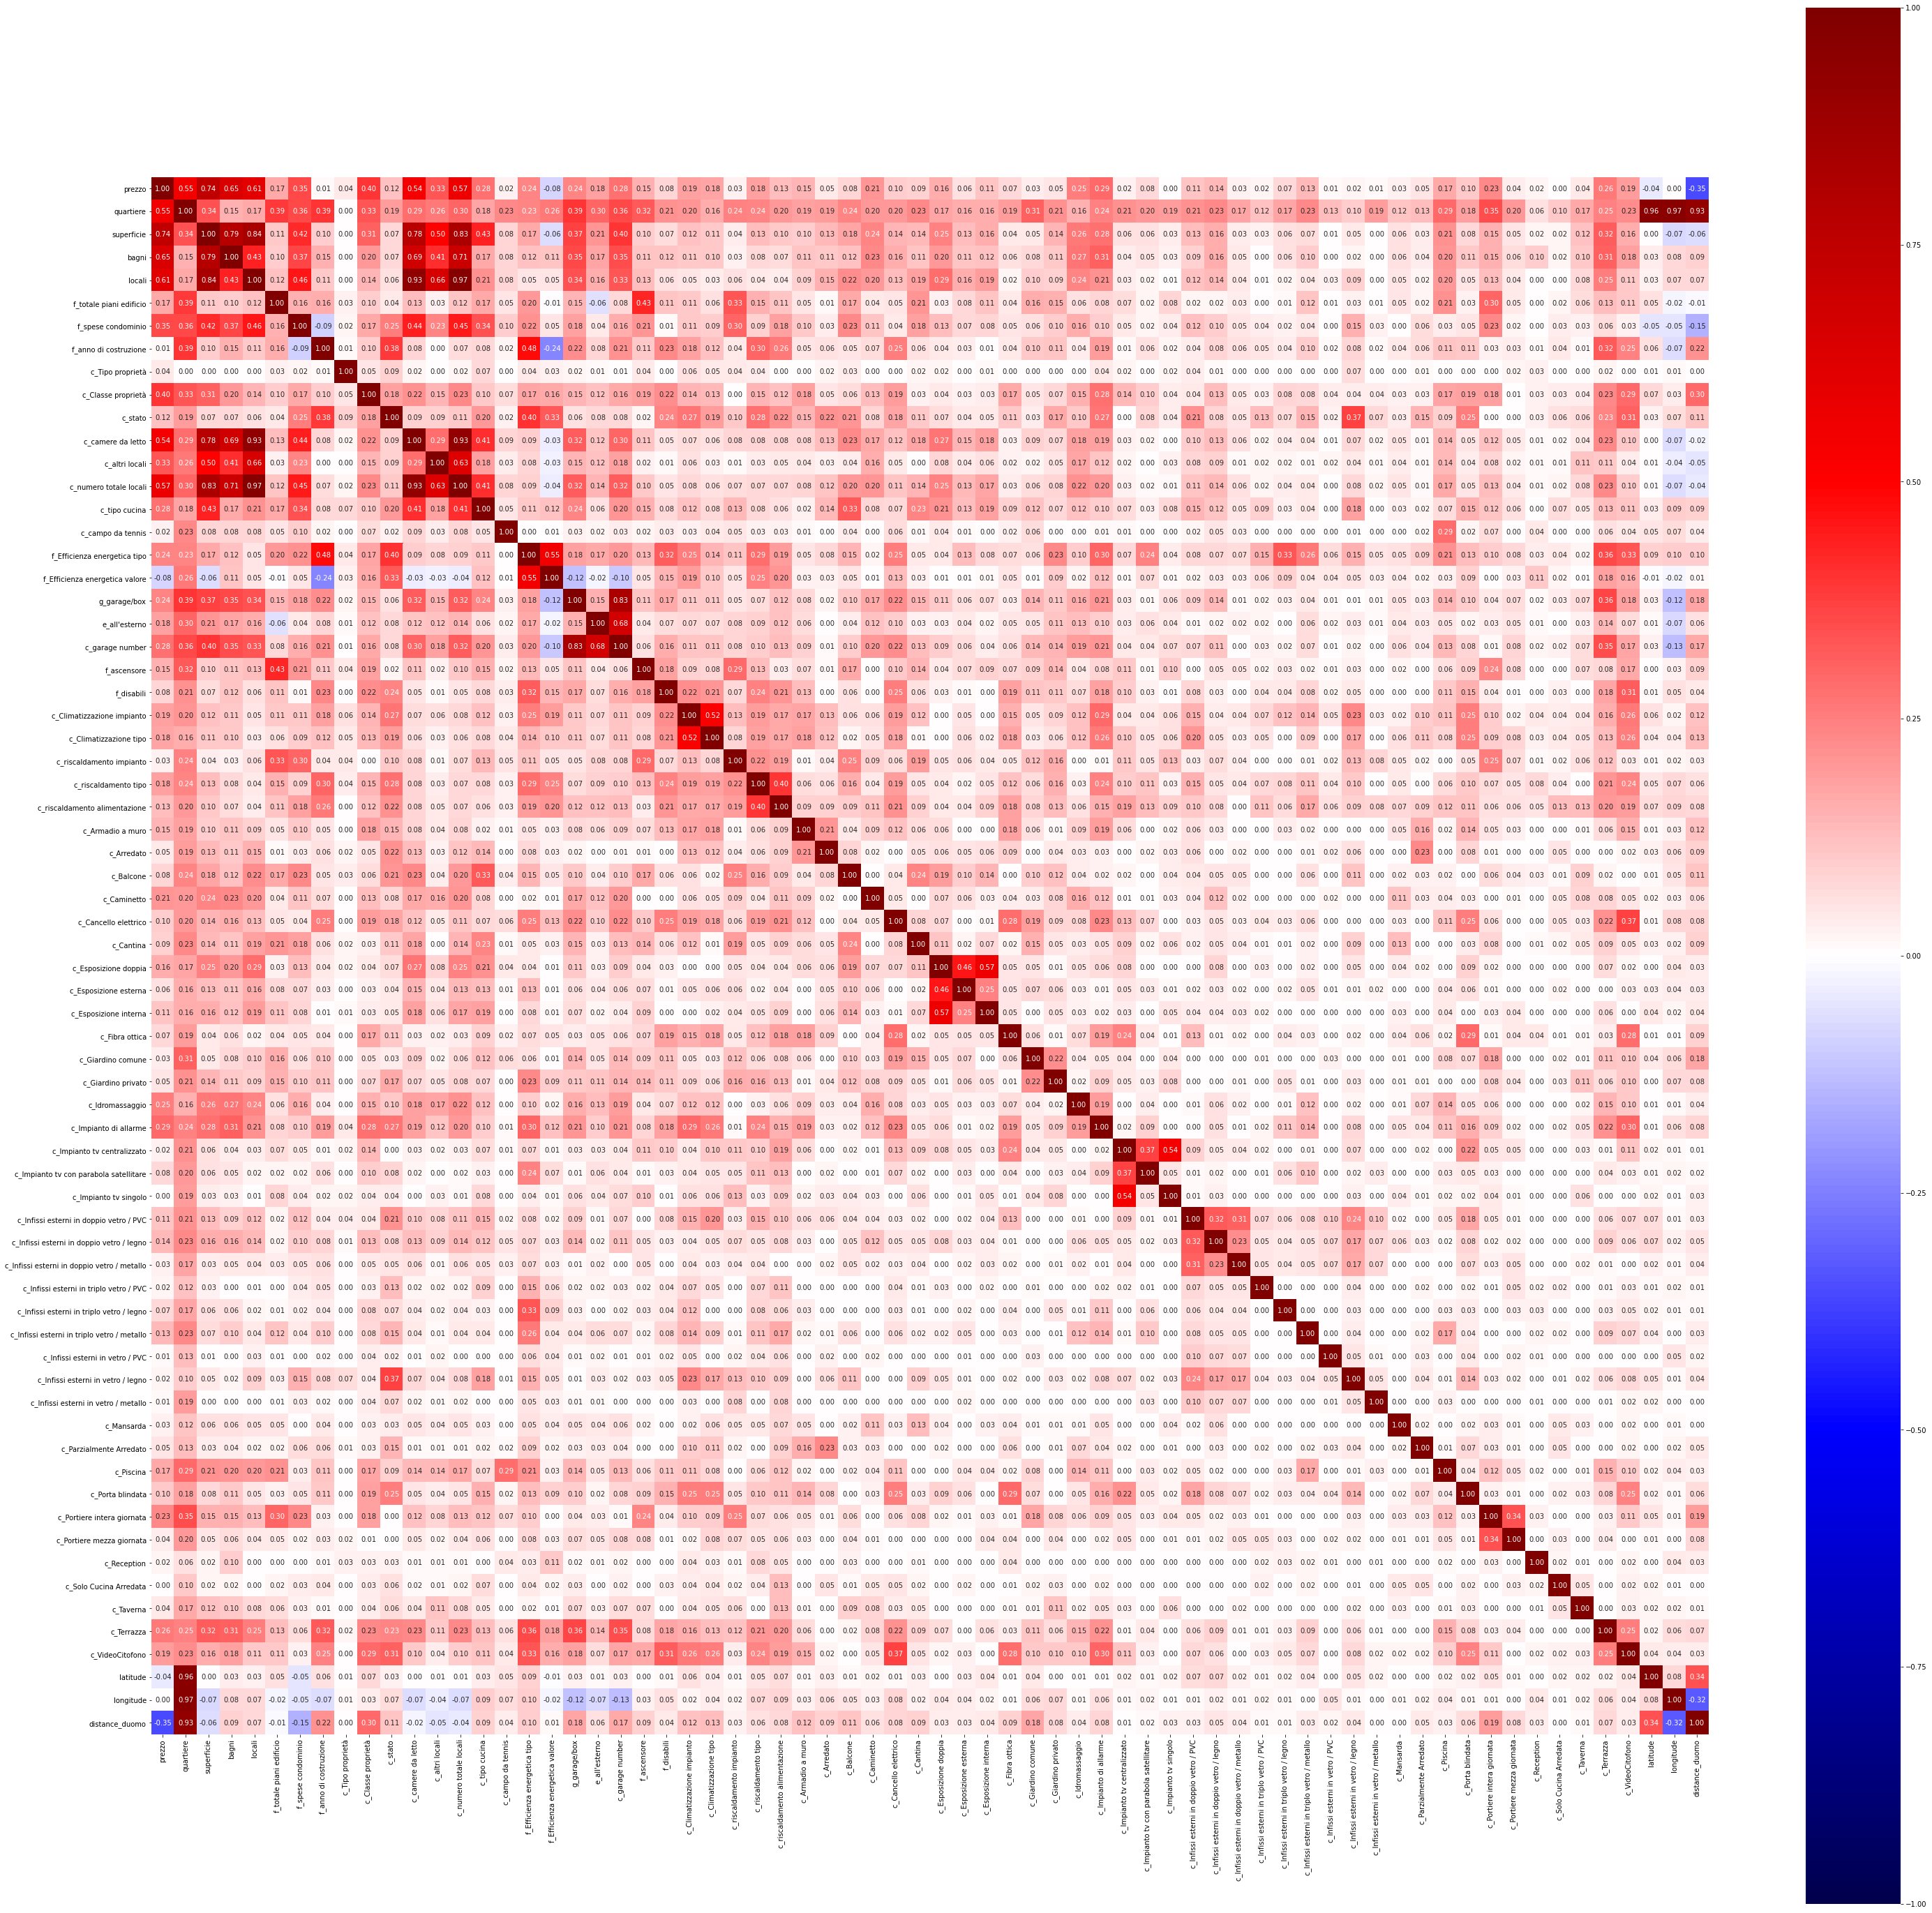

In [77]:
# Filter columns

columns_filtered = [
  #'id',
  'prezzo',
  'quartiere',
  'superficie',
  'bagni',
  #'piano',
  'locali',
  'f_totale piani edificio',
  'f_spese condominio',
  'f_anno di costruzione',
  'c_Tipo proprietà',
  'c_Classe proprietà',
  'c_stato',
  'c_camere da letto',
  'c_altri locali',
  'c_numero totale locali',
  'c_tipo cucina',
  'c_campo da tennis',
  'f_Efficienza energetica tipo',
  'f_Efficienza energetica valore',
  #'indirizzo_2',
  'g_garage/box',
  "e_all'esterno",
  'c_garage number',
  'f_ascensore',
  'f_disabili',
  'c_Climatizzazione impianto',
  'c_Climatizzazione tipo',
  'c_riscaldamento impianto',
  'c_riscaldamento tipo',
  'c_riscaldamento alimentazione',
  'c_Armadio a muro',
  'c_Arredato',
  'c_Balcone',
  'c_Caminetto',
  'c_Cancello elettrico',
  'c_Cantina',
  'c_Esposizione doppia',
  'c_Esposizione esterna',
  'c_Esposizione interna',
  'c_Fibra ottica',
  'c_Giardino comune',
  'c_Giardino privato',
  'c_Idromassaggio',
  'c_Impianto di allarme',
  'c_Impianto tv centralizzato',
  'c_Impianto tv con parabola satellitare',
  'c_Impianto tv singolo',
  'c_Infissi esterni in doppio vetro / PVC',
  'c_Infissi esterni in doppio vetro / legno',
  'c_Infissi esterni in doppio vetro / metallo',
  'c_Infissi esterni in triplo vetro / PVC',
  'c_Infissi esterni in triplo vetro / legno',
  'c_Infissi esterni in triplo vetro / metallo',
  'c_Infissi esterni in vetro / PVC',
  'c_Infissi esterni in vetro / legno',
  'c_Infissi esterni in vetro / metallo',
  'c_Mansarda',
  'c_Parzialmente Arredato',
  'c_Piscina',
  'c_Porta blindata',
  'c_Portiere intera giornata',
  'c_Portiere mezza giornata',
  'c_Reception',
  'c_Solo Cucina Arredata',
  'c_Taverna',
  'c_Terrazza',
  'c_VideoCitofono',
  #'geocode_address',
  #'geocode_point',
  'latitude',
  'longitude',
  #'distance_duomo'
]

columns_geo = [
  'distance_duomo'
]

# Merge columns to keep
columns_filtered = columns_filtered + columns_geo 

# Nominal columns
columns_nominal = [
  #'id',
  'quartiere',
  #'prezzo',
  #'superficie',
  'bagni',
  #'piano',
  'locali',
  #'f_totale piani edificio',
  #'f_spese condominio',
  #'f_anno di costruzione',
  'c_Tipo proprietà',
  'c_Classe proprietà',
  'c_stato',
  #'c_camere da letto',
  #'c_altri locali',
  #'c_numero totale locali',
  'c_tipo cucina',
  'c_campo da tennis',
  'f_Efficienza energetica tipo',
  #'f_Efficienza energetica valore',
  #'indirizzo_2',
  #'g_garage/box',
  #"e_all'esterno",
  #'c_garage number',
  'f_ascensore',
  'f_disabili',
  'c_Climatizzazione impianto',
  'c_Climatizzazione tipo',
  'c_riscaldamento impianto',
  'c_riscaldamento tipo',
  'c_riscaldamento alimentazione',
  'c_Armadio a muro',
  'c_Arredato',
  'c_Balcone',
  'c_Caminetto',
  'c_Cancello elettrico',
  'c_Cantina',
  'c_Esposizione doppia',
  'c_Esposizione esterna',
  'c_Esposizione interna',
  'c_Fibra ottica',
  'c_Giardino comune',
  'c_Giardino privato',
  'c_Idromassaggio',
  'c_Impianto di allarme',
  'c_Impianto tv centralizzato',
  'c_Impianto tv con parabola satellitare',
  'c_Impianto tv singolo',
  'c_Infissi esterni in doppio vetro / PVC',
  'c_Infissi esterni in doppio vetro / legno',
  'c_Infissi esterni in doppio vetro / metallo',
  'c_Infissi esterni in triplo vetro / PVC',
  'c_Infissi esterni in triplo vetro / legno',
  'c_Infissi esterni in triplo vetro / metallo',
  'c_Infissi esterni in vetro / PVC',
  'c_Infissi esterni in vetro / legno',
  'c_Infissi esterni in vetro / metallo',
  'c_Mansarda',
  'c_Parzialmente Arredato',
  'c_Piscina',
  'c_Porta blindata',
  'c_Portiere intera giornata',
  'c_Portiere mezza giornata',
  'c_Reception',
  'c_Solo Cucina Arredata',
  'c_Taverna',
  'c_Terrazza',
  'c_VideoCitofono',
  #'geocode_address',
  #'geocode_point',
  #'latitude',
  #'longitude',
  #'distance_duomo'
]

df_eda = df_eda[columns_filtered]

associations_dictionary = associations(df_eda, nan_strategy='replace', nan_replace_value='', nominal_columns=columns_nominal, figsize=(50, 50), cmap='seismic', mark_columns=False)

associations_corr = associations_dictionary['corr']

In [ ]:
# Select columns to drop because lower than correlation threshold

corr_threshold = 0.1
column_to_drop = associations_corr.columns[abs(associations_corr['prezzo']) > corr_threshold].tolist()
column_to_drop

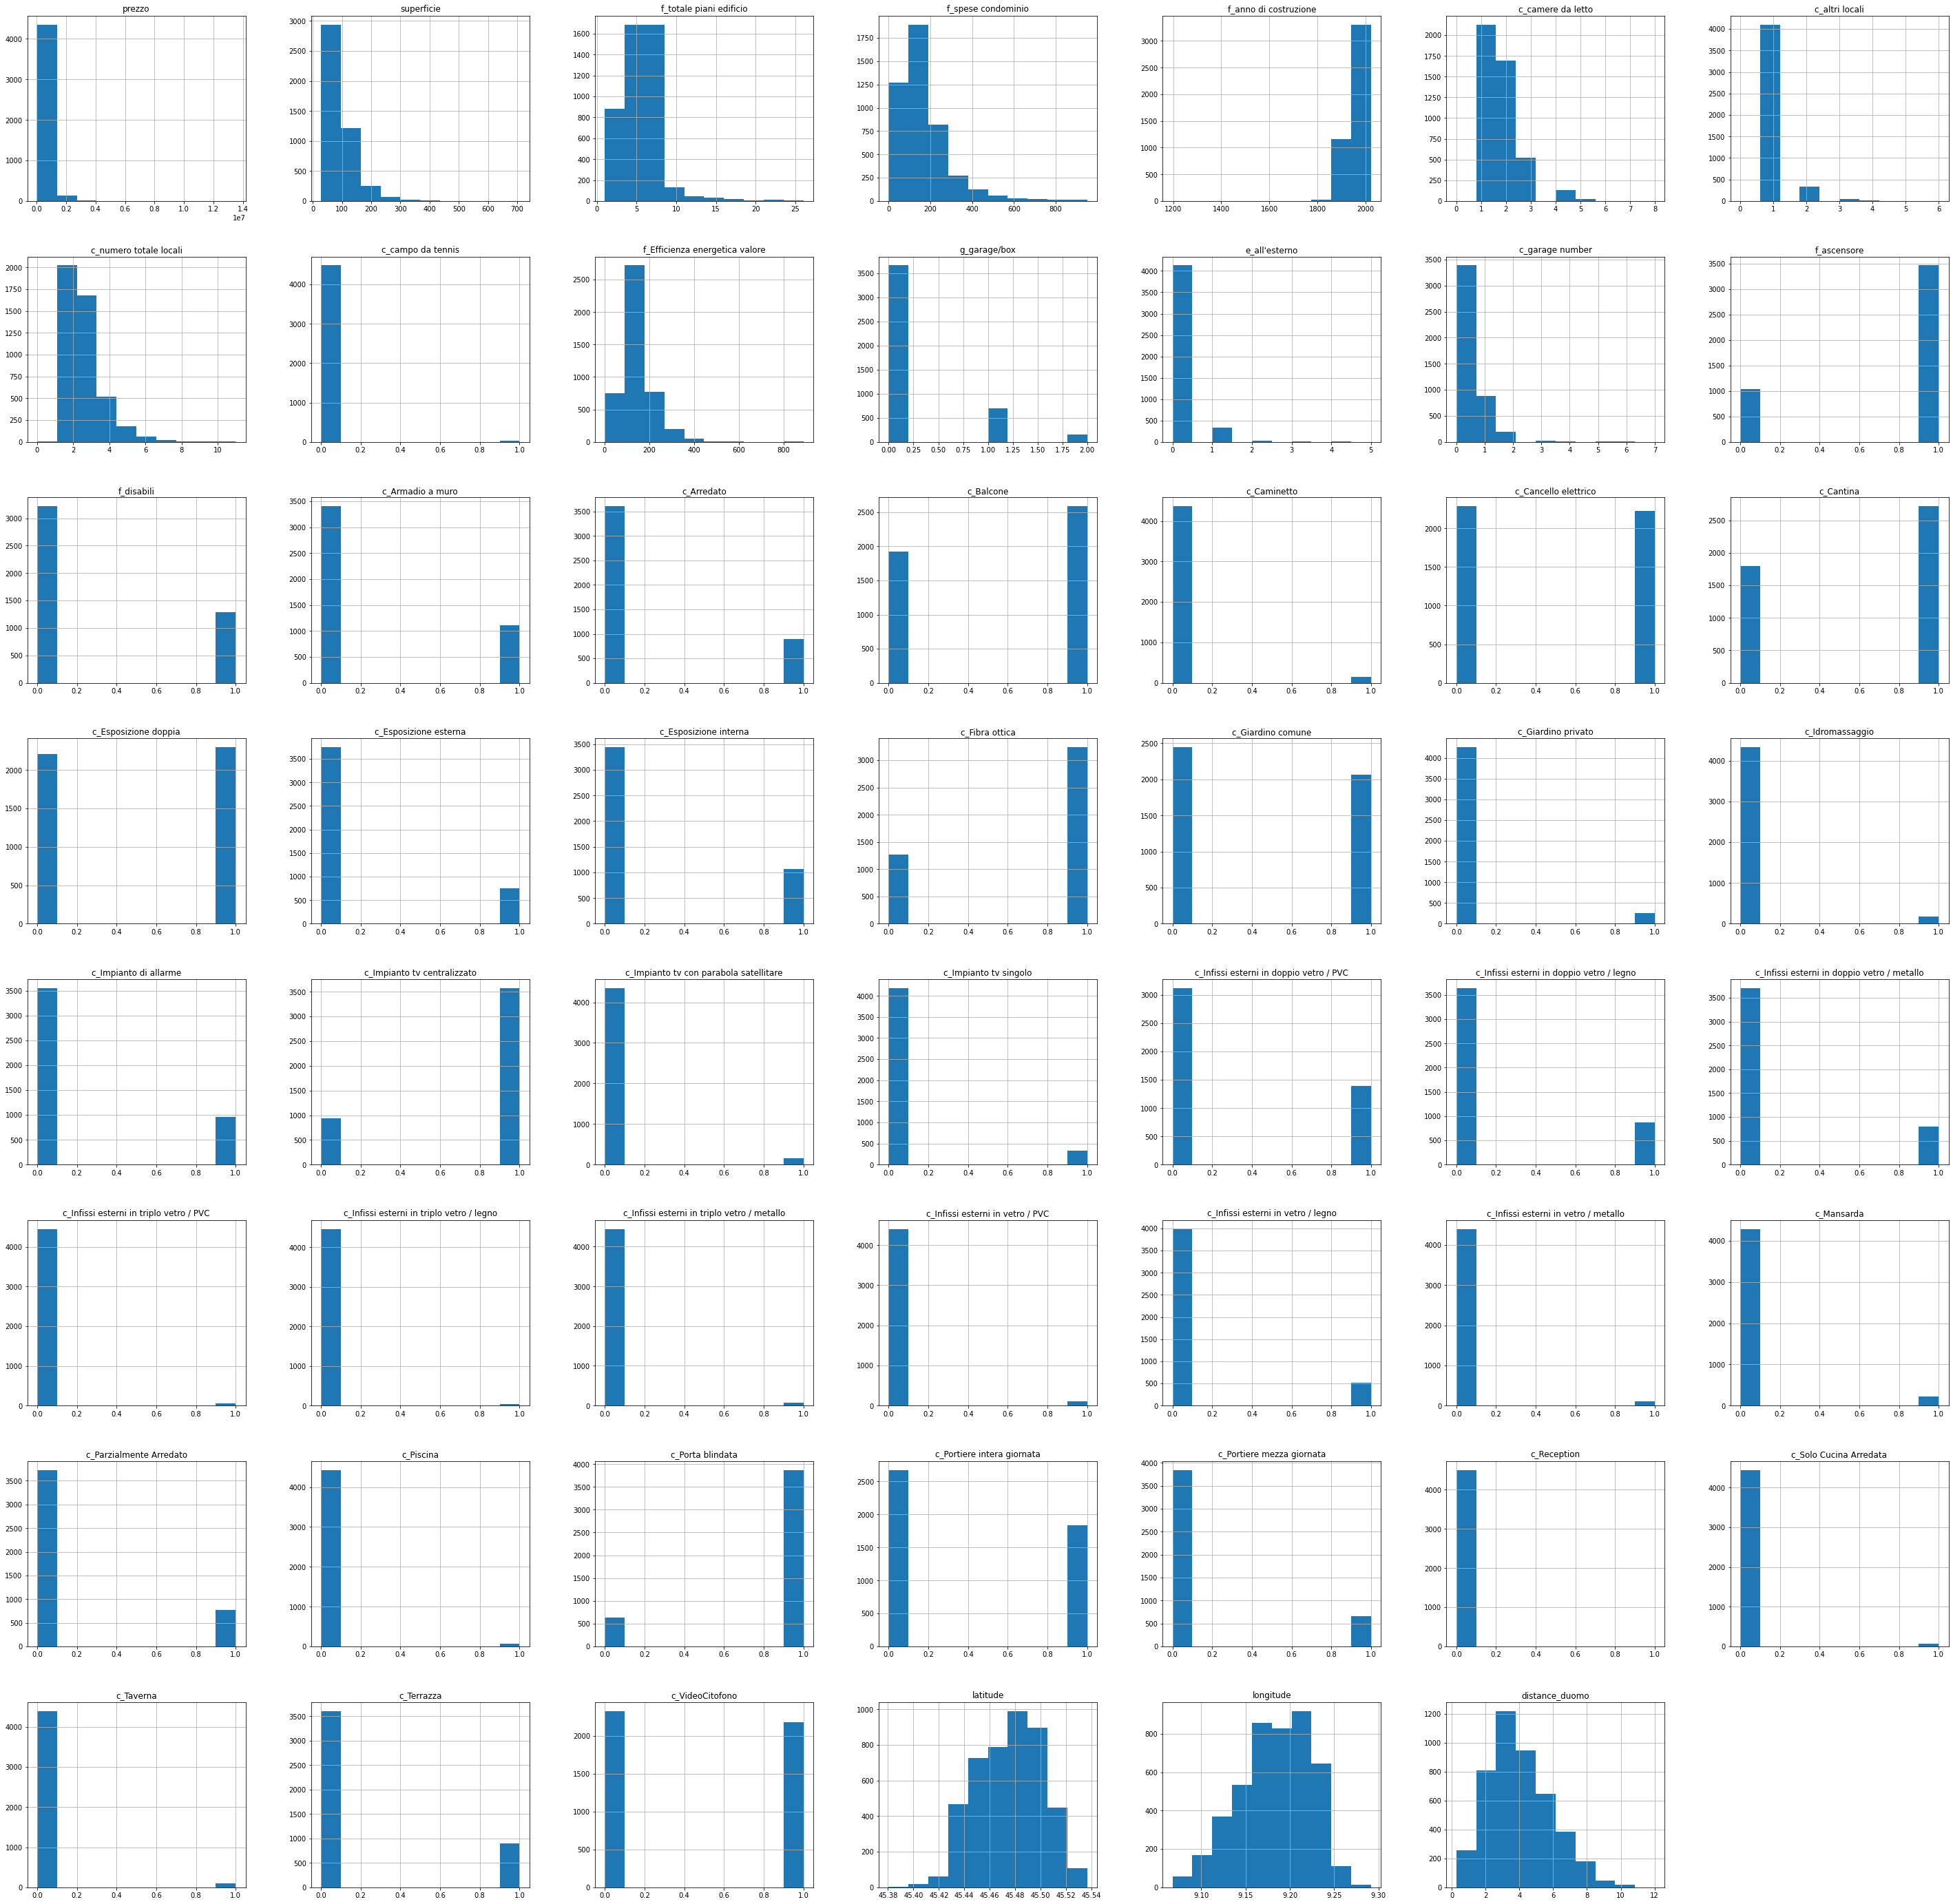

In [79]:
# Histograms

df_eda.hist(figsize = (50, 50))
plt.show()

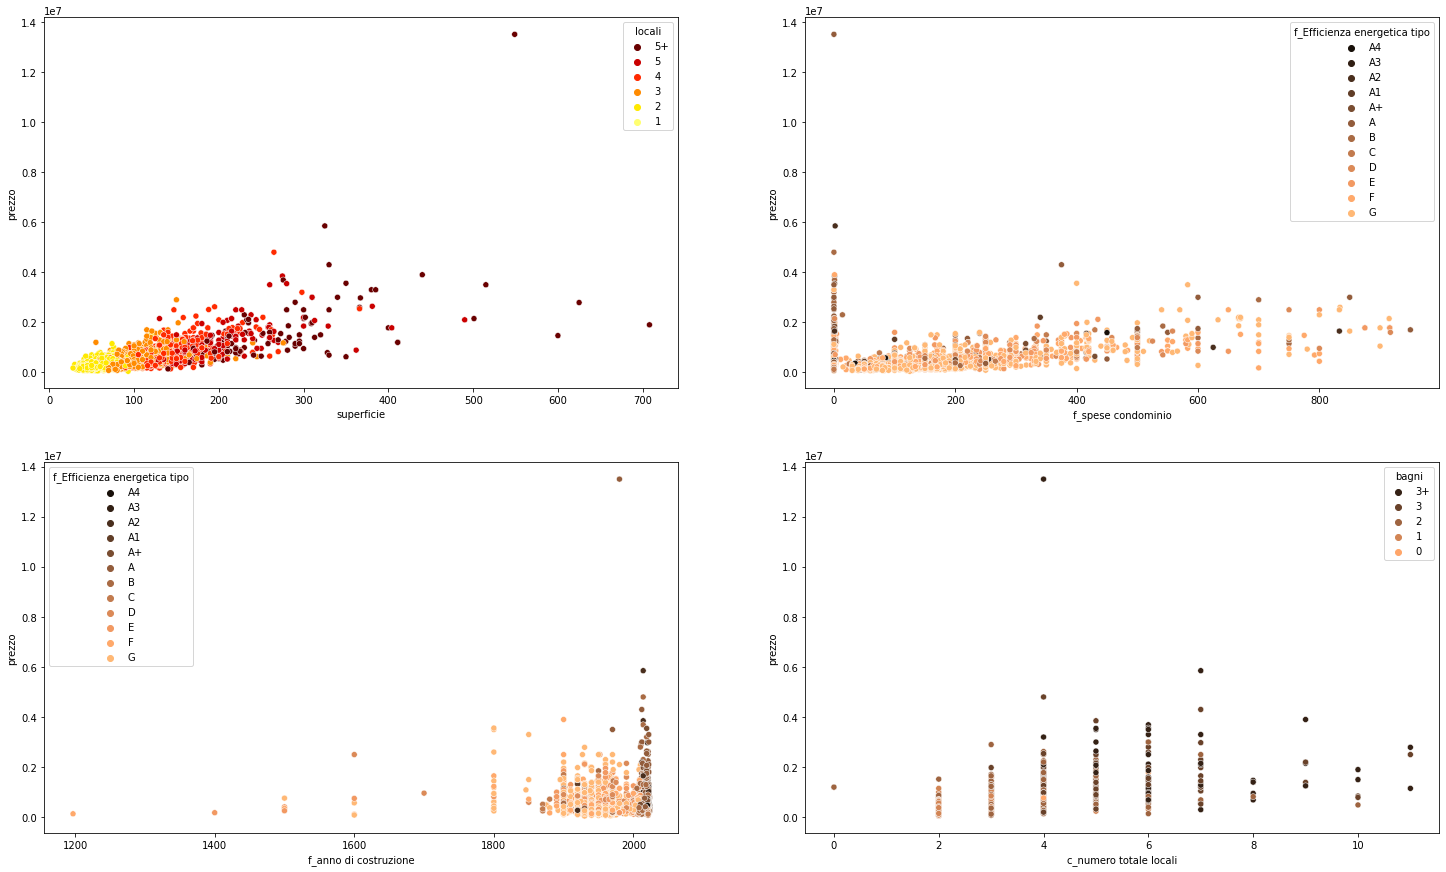

In [80]:
# Scatterplots

fig = plt.figure(figsize=(25, 15))

fig.add_subplot(2, 2, 1)
locali_order = ['5+', '5', '4', '3', '2', '1']
sb.scatterplot(x='superficie', y='prezzo', data=df_eda, hue="locali", hue_order=locali_order, palette='hot')

fig.add_subplot(2, 2, 2)
eet_order = ['A4', 'A3', 'A2', 'A1', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
sb.scatterplot(x='f_spese condominio', y='prezzo', data=df_eda, hue='f_Efficienza energetica tipo', hue_order=eet_order, palette='copper')

fig.add_subplot(2, 2, 3)
eet_order = ['A4', 'A3', 'A2', 'A1', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
sb.scatterplot(x='f_anno di costruzione', y='prezzo', data=df_eda, hue='f_Efficienza energetica tipo', hue_order=eet_order, palette='copper')

fig.add_subplot(2, 2, 4)
bagni_order = ['3+', '3', '2', '1', '0']
sb.scatterplot(x='c_numero totale locali', y='prezzo', data=df_eda, hue='bagni', hue_order=bagni_order, palette='copper')

Text(0, 0.5, 'Frequency')

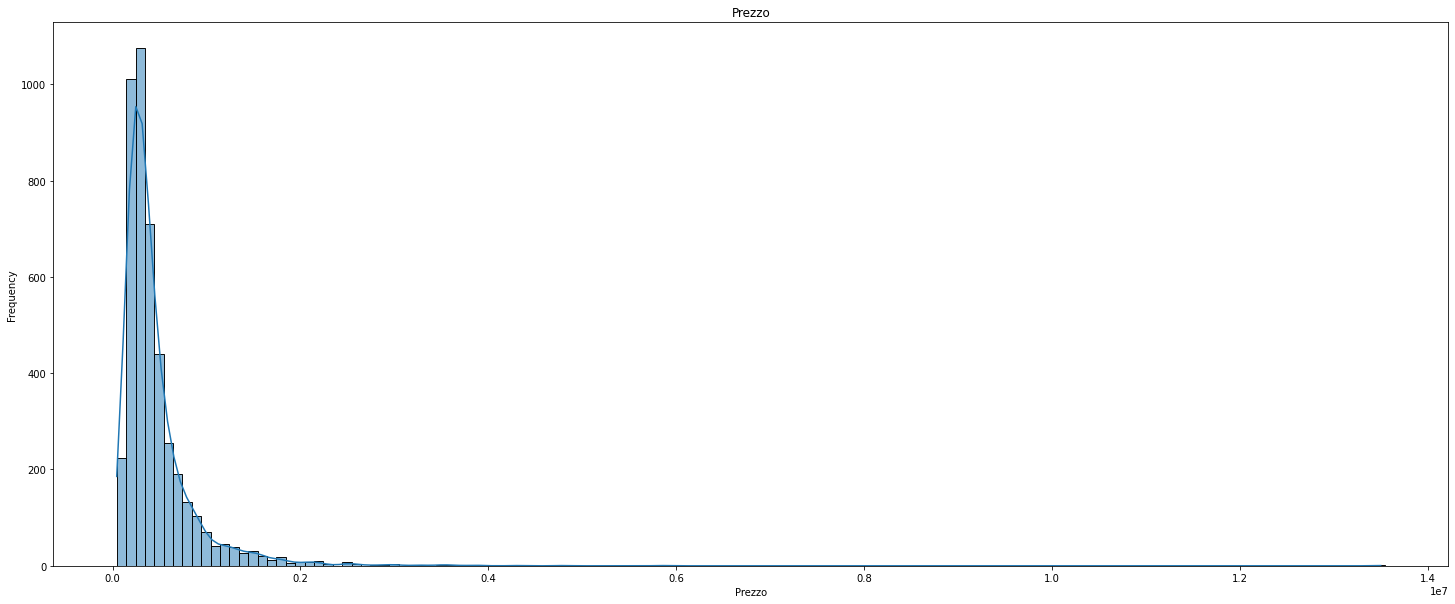

In [81]:
# Histogram of prices

fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sb.histplot(df_eda['prezzo'], ax=ax, binwidth=100000, kde=True)

plt.title('Prezzo')

plt.xlabel('Prezzo')
plt.ylabel('Frequency')

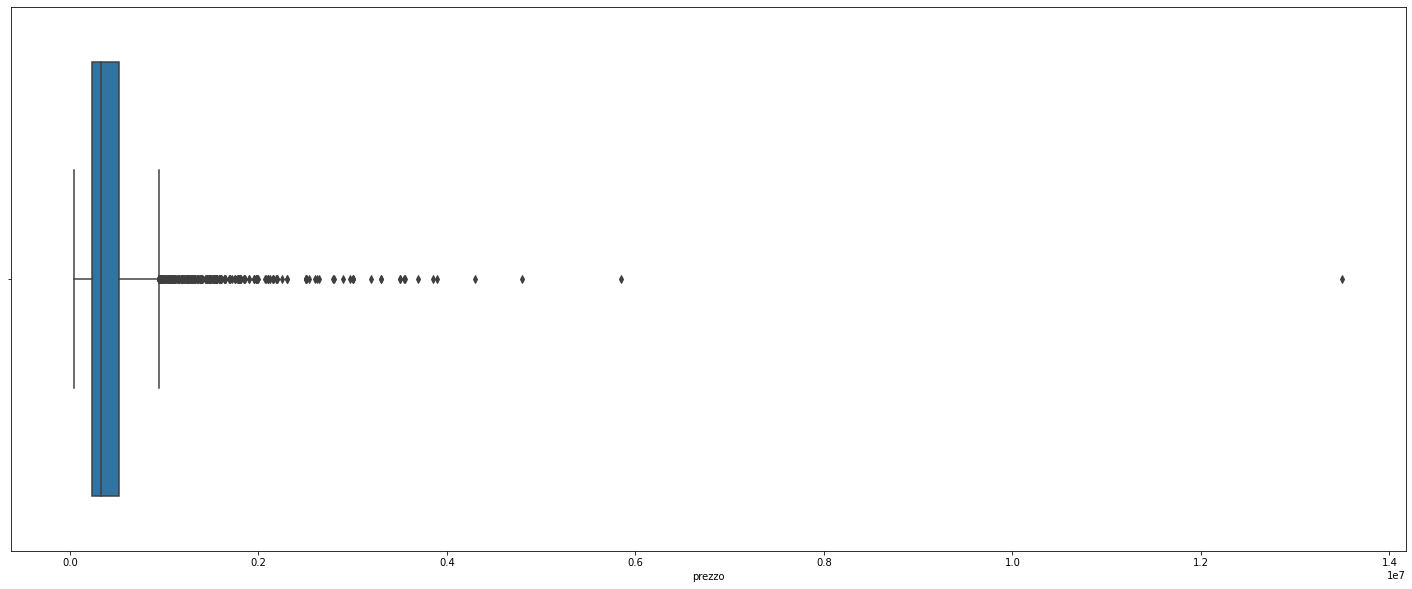

In [82]:
# Boxplot of prices

fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sb.boxplot(x=df_eda['prezzo'], ax=ax)

In [83]:
# Show real estate in a heatmap based on their geographical coordinates and weighted on their price

def generateBaseMap(default_location=[45.4641, 9.1919], default_zoom_start=12):
  base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
  return base_map

base_map = generateBaseMap()
HeatMap(data=df_eda[['latitude', 'longitude', 'prezzo']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=17, max_zoom=5, max_val=df_eda['prezzo'].max()).add_to(base_map)
base_map

## Artificial Neural Network

In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, BatchNormalization, Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import feature_selection

### One-Hot Encoding

In [ ]:
files.upload()

In [7]:
csv_ads_hot = 'ads_geocode_1620485970.csv'
df_ads_hot = pd.read_csv(csv_ads_hot)

In [106]:
columns_filtered = [
  'prezzo',
  'quartiere',
  'superficie',
  'bagni',
  'locali',
  'f_totale piani edificio',
  'f_spese condominio',
  'c_Classe proprietà',
  'c_stato',
  'c_camere da letto',
  'c_altri locali',
  'c_numero totale locali',
  'c_tipo cucina',
  'f_Efficienza energetica tipo',
  'g_garage/box',
  "e_all'esterno",
  'c_garage number',
  'f_ascensore',
  'c_Climatizzazione impianto',
  'c_Climatizzazione tipo',
  'c_riscaldamento tipo',
  'c_riscaldamento alimentazione',
  'c_Armadio a muro',
  'c_Caminetto',
  'c_Esposizione doppia',
  'c_Esposizione interna',
  'c_Idromassaggio',
  'c_Impianto di allarme',
  'c_Infissi esterni in doppio vetro / PVC',
  'c_Infissi esterni in doppio vetro / legno',
  'c_Infissi esterni in triplo vetro / metallo',
  'c_Piscina',
  'c_Porta blindata',
  'c_Portiere intera giornata',
  'c_Terrazza',
  'c_VideoCitofono',
  'distance_duomo'
]

df_ads_hot = df_ads_hot.filter(items=columns_filtered)

In [107]:
list(df_ads_hot.columns)

['prezzo',
 'quartiere',
 'superficie',
 'bagni',
 'locali',
 'f_totale piani edificio',
 'f_spese condominio',
 'c_Classe proprietà',
 'c_stato',
 'c_camere da letto',
 'c_altri locali',
 'c_numero totale locali',
 'c_tipo cucina',
 'f_Efficienza energetica tipo',
 'g_garage/box',
 "e_all'esterno",
 'c_garage number',
 'f_ascensore',
 'c_Climatizzazione impianto',
 'c_Climatizzazione tipo',
 'c_riscaldamento tipo',
 'c_riscaldamento alimentazione',
 'c_Armadio a muro',
 'c_Caminetto',
 'c_Esposizione doppia',
 'c_Esposizione interna',
 'c_Idromassaggio',
 'c_Impianto di allarme',
 'c_Infissi esterni in doppio vetro / PVC',
 'c_Infissi esterni in doppio vetro / legno',
 'c_Infissi esterni in triplo vetro / metallo',
 'c_Piscina',
 'c_Porta blindata',
 'c_Portiere intera giornata',
 'c_Terrazza',
 'c_VideoCitofono',
 'distance_duomo']

In [108]:
dummies_dict = {
  ('quartiere', 'q'),
  ('bagni', 'b'),
  ('locali', 'l'),
  ('c_Classe proprietà', 'cp'),
  ('c_stato', 's'),
  ('c_tipo cucina', 'tc'),
  ('f_Efficienza energetica tipo', 'eet'),
  ('c_Climatizzazione impianto', 'ci'),
  ('c_Climatizzazione tipo', 'ct'),
  ('c_riscaldamento tipo', 'rt'),
  ('c_riscaldamento alimentazione', 'ra')
}

def dummies(df, dummies_dict):
  for column in dummies_dict:
    df = pd.concat([df, pd.get_dummies(df[column[0]], prefix=column[1])], axis=1)
    df.drop([column[0]], axis=1, inplace=True)
  return df

df_ads_hot = dummies(df_ads_hot, dummies_dict)

In [109]:
print(df_ads_hot.info())
display(df_ads_hot.describe().transpose())
display(df_ads_hot.head(10).T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Columns: 221 entries, prezzo to rt_ad aria
dtypes: float64(1), int64(25), uint8(195)
memory usage: 1.7 MB
None


,count,mean,std,min,25%,50%,75%,max
prezzo,4507.0,458742.981584,447423.006208,45000.000000,235000.000000,335000.000000,520000.00000,1.350000e+07
superficie,4507.0,93.454626,52.348251,28.000000,60.000000,80.000000,110.00000,7.080000e+02
f_totale piani edificio,4507.0,5.373197,2.683988,1.000000,4.000000,5.000000,7.00000,2.600000e+01
f_spese condominio,4507.0,154.556468,128.981347,0.000000,80.000000,133.000000,200.00000,9.500000e+02
c_camere da letto,4507.0,1.722432,0.842944,0.000000,1.000000,2.000000,2.00000,8.000000e+00
c_altri locali,4507.0,1.110717,0.406274,0.000000,1.000000,1.000000,1.00000,6.000000e+00
c_numero totale locali,4507.0,2.832927,1.035670,0.000000,2.000000,3.000000,3.00000,1.100000e+01
g_garage/box,4507.0,0.220324,0.488714,0.000000,0.000000,0.000000,0.00000,2.000000e+00
e_all'esterno,4507.0,0.099401,0.370778,0.000000,0.000000,0.000000,0.00000,5.000000e+00
c_garage number,4507.0,0.319725,0.656200,0.000000,0.000000,0.000000,0.00000,7.000000e+00


,0,1,2,3,4,5,6,7,8,9
prezzo,680000.000000,225000.000000,320000.000000,1.150000e+06,445000.000000,360000.000000,315000.000000,295000.000000,390000.000000,450000.000000
superficie,168.000000,52.000000,80.000000,1.600000e+02,80.000000,40.000000,45.000000,70.000000,40.000000,78.000000
f_totale piani edificio,6.000000,4.000000,4.000000,6.000000e+00,7.000000,4.000000,6.000000,5.000000,5.000000,3.000000
f_spese condominio,300.000000,133.000000,71.000000,3.000000e+02,250.000000,100.000000,158.000000,250.000000,125.000000,200.000000
c_camere da letto,2.000000,1.000000,2.000000,3.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
c_altri locali,1.000000,1.000000,1.000000,2.000000e+00,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000
c_numero totale locali,3.000000,2.000000,3.000000,5.000000e+00,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000
g_garage/box,1.000000,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
e_all'esterno,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
c_garage number,1.000000,1.000000,0.000000,2.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [111]:
csv_ads_hot = 'ads_hot_' + get_timestamp() + '.csv'
df_ads_hot.to_csv(csv_ads_hot, index=False)
files.download(csv_ads_hot)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Configuration

In [ ]:
!pip install h5py
!pip install -U keras-tuner
!pip install kerastuner-tensorboard-logger

import datetime
import tensorflow as tf

import kerastuner as kt
from kerastuner.tuners import Hyperband
from kerastuner import HyperModel

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

from kerastuner_tensorboard_logger import (
  TensorBoardLogger,
  setup_tb
)

In [ ]:
files.upload()

In [37]:
csv_ads_hot = 'ads_hot_1620489950.csv'
df_ads_hot = pd.read_csv(csv_ads_hot)

In [38]:
# Convert all data to numeric types
df_ads_hot = df_ads_hot.apply(pd.to_numeric)

In [ ]:
print(df_ads_hot.info())
display(df_ads_hot.describe().transpose())
display(df_ads_hot.head(10).T)

In [ ]:
# Optional: filter further data

print(len(df_ads_hot.index))

df_ads_hot = df_ads_hot[df_ads_hot['cp_classe immobile signorile'] == 1]
df_ads_hot = df_ads_hot[df_ads_hot['superficie'] < 200]
df_ads_hot = df_ads_hot[df_ads_hot['b_3+'] != 1.0]
df_ads_hot = df_ads_hot[df_ads_hot['c_numero totale locali'] < 6]
df_ads_hot = df_ads_hot[df_ads_hot['l_5+'] != 1.0]

print(len(df_ads_hot.index))

In [39]:
# Drop all rows with at least a NaN value

print(df_ads_hot.shape)

df_ads_hot = df_ads_hot.dropna()

print(df_ads_hot.shape)

(4507, 221)
(4507, 221)


In [40]:
X = df_ads_hot.drop('prezzo', axis=1)
y = df_ads_hot[['prezzo']]

In [41]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)

In [42]:
# Standardize all columns

# Columns with continuos values
columns_standard = [
  'superficie',
  'f_totale piani edificio',
  'f_spese condominio',
  'c_camere da letto',
  'c_altri locali',
  'c_numero totale locali',
  'g_garage/box',
  'e_all\'esterno',
  'c_garage number',
  'distance_duomo',
]

ct_data = ColumnTransformer(transformers = [('ct_data', StandardScaler(), columns_standard)], remainder ='passthrough')
ct_target = StandardScaler()

# Fit standardization ONLY on training set and then apply to validation and test sets.
X_train_scaled = ct_data.fit_transform(X_train)
y_train_scaled = ct_target.fit_transform(y_train)

X_val_scaled = ct_data.transform(X_val)
y_val_scaled = ct_target.transform(y_val)

X_test_scaled = ct_data.transform(X_test)
y_test_scaled = ct_target.transform(y_test)

#### Curse of dimensionality

* Dimensionality-reduction methods are used to remove features in datasets at the expense of accuracy, but reaching semplicity to make much more easier to analyze them by machine learning algorithms.

* Principal Component Analysis (PCA): combine features in fewer feature and then remove useless of them.

In [22]:
# Principal Component Analysis (PCA)

pca = PCA(0.90)

X_train_scaled = pca.fit_transform(X_train_scaled)
X_val_scaled = pca.transform(X_val_scaled)
X_test_scaled = pca.transform(X_test_scaled)

In [ ]:
# Select best K features

k_best = SelectKBest(score_func=f_classif, k=100)

fit = k_best.fit(X_train, y_train)

univariate_features = fit.transform(X_train)

In [ ]:
# Variance Threshold

print(X_train_scaled.shape)

variance_treshold = 0.001
variance_threshold = feature_selection.VarianceThreshold(threshold=variance_treshold)

X_train_scaled = variance_threshold.fit_transform(X_train_scaled)
X_val_scaled = variance_threshold.transform(X_val_scaled)
X_test_scaled = variance_threshold.transform(X_test_scaled)

print(X_train_scaled.shape)

### Tuning

* [Keras Tuner](https://keras-team.github.io/keras-tuner/) is a open-source library that allow you to tune Hyperparameters of your Neural Network. <br>
How many **layers** do you need? How many **neurons** per layer is needed? What type of **activation functions** fit well?

In [43]:
# Subclass of HyperModel

class MyHyperModel(HyperModel):

  def build(self, hp):
    model = Sequential()
    
    # Input Layer
    model.add(InputLayer((X_train_scaled.shape[1],)))
    
    # Define a random quantity of layers between min_value and max_value inclused
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    for i in range(num_layers):

      # If current selected layer is the first set dropout max value to 0.2, 
      # instead for all hidden layers to 0.5
      dropout_max_value = 0.5
      if i == 0:
        dropout_max_value = 0.2

      # Dense Layer
      model.add(
        Dense(
            units=hp.Int(
              'units_' + str(i + 1),
              min_value=8,
              max_value=256,
              default=64,
              step=8),
              kernel_initializer='normal'
        )
      )

      # Batch Normalization
      model.add(BatchNormalization())
      
      # Activation function
      model.add(Activation(hp.Choice(
                    'activation_' + str(i + 1),
                    values=['relu', 'tanh', 'sigmoid', 'linear'],
                    default='relu')))
      # Dropout
      model.add(
        Dropout(
          rate=hp.Float(
            'dropout_' + str(i + 1),
            min_value=0,
            max_value=dropout_max_value,
            step=0.1,
            default=0
          )
        )
      )

    # Last dense layer composed of only one neuron because it returns just a
    # single value: the price predicted
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    
    # Adam optimizer and its learning rate range
    adam = keras.optimizers.Adam(
        learning_rate=hp.Float(
            'learning_rate',
            min_value=1e-5,
            max_value=1e-3,
            sampling='LOG',
            default=1e-3)
        )
    
    # Compile the model defined with optimizer and metric
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

    return model

hypermodel = MyHyperModel()

In [44]:
keras_tuner_directory = 'keras_tuner_' + get_timestamp()
keras_tuner_project_name = 'real_estate_' + get_timestamp()

'''
hyperparameters = HyperParameters()

hyperparameters.Float(
  'learning_rate',
  min_value=1e-5,
  max_value=1e-3,
  sampling='LOG',
  default=1e-3
)

hyperparameters.Int('num_layers', 2, 3)
'''

tuner = Hyperband(
  hypermodel=hypermodel,
  #hyperparameters=hyperparameters,
  objective='val_loss',
  max_epochs=100,
  logger=TensorBoardLogger(
    metrics=["val_loss"], logdir="logs/hparams"
  ),
  directory=keras_tuner_directory,
  project_name=keras_tuner_project_name
)

In [ ]:
tuner.search_space_summary()

In [46]:
# Set Early Stopping to stop training until validation error not increse
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [47]:
# Before start tuning process remove /logs folder
!rm -rf ./logs/

In [48]:
# Starts tuning process

tuner.search(
  X_train_scaled,
  y_train_scaled,
  epochs=200,
  validation_data=(X_val_scaled, y_val_scaled),
  callbacks=[es]
)

Trial 254 Complete [00h 00m 48s]
val_loss: 0.07928558439016342

Best val_loss So Far: 0.06279200315475464
Total elapsed time: 00h 23m 21s
INFO:tensorflow:Oracle triggered exit


In [50]:
# Get tuner summary results
tuner.results_summary(1)

Results summary
Results in keras_tuner_1620507909/real_estate_1620507909
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 4
units_1: 184
activation_1: linear
dropout_1: 0.1
learning_rate: 0.00026310392849096797
units_2: 192
activation_2: relu
dropout_2: 0.1
units_3: 192
activation_3: linear
dropout_3: 0.30000000000000004
units_4: 72
activation_4: tanh
dropout_4: 0.30000000000000004
units_5: 240
activation_5: tanh
dropout_5: 0.5
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.06279200315475464


In [51]:
# Get best Hyperparameters found
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [52]:
# Set model with best Hyprparameters
model = tuner.hypermodel.build(best_hyperparameters)

In [53]:
# Get best Learning Rate found
# ATTENTION: save this manually because it is outside model architecture
learning_rate = best_hyperparameters['learning_rate']

In [54]:
# Save best model architecture found through Keras Tuner
keras_tuner_model = 'keras_tuner_model_' + get_timestamp() + '.h5'
model.save(keras_tuner_model)
files.download(keras_tuner_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Training

#### Load model architecture

In [55]:
# Load best model architecture
model = load_model('keras_tuner_model_1620511303.h5')

In [56]:
# Get best model architecture
model_config = model.get_config()

In [57]:
# Create a new model with best architecture
model = Sequential.from_config(model_config)

In [58]:
# Instantiate optimizer with learning rate loaded before
adam = keras.optimizers.Adam(learning_rate=learning_rate)

In [59]:
# Compile model with optimizer and metrics
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

#### Cross-Validation

In [60]:
csv_ads_hot = 'ads_hot_1620489950.csv'
df_ads_hot = pd.read_csv(csv_ads_hot)

In [61]:
df_ads_hot = df_ads_hot.apply(pd.to_numeric)

In [62]:
X = df_ads_hot.drop('prezzo', axis=1)
y = df_ads_hot[['prezzo']]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [64]:
n_splits=10
k_fold = KFold(n_splits=n_splits, shuffle=True)
val_losses = []

i = 0
history = [None] * n_splits

for train_indices, val_indices in k_fold.split(X_train):

  X_train, X_val = X.iloc[list(train_indices)], X.iloc[list(val_indices)]
  y_train, y_val = y.iloc[list(train_indices)], y.iloc[list(val_indices)]

  columns_standard = [
    'superficie',
    'f_totale piani edificio',
    'f_spese condominio',
    'c_camere da letto',
    'c_altri locali',
    'c_numero totale locali',
    'g_garage/box',
    'e_all\'esterno',
    'c_garage number',
    'distance_duomo',
  ]

  ct_data = ColumnTransformer(transformers = [('ct_data', StandardScaler(), columns_standard)], remainder ='passthrough')
  ct_target = StandardScaler()

  X_train_scaled = ct_data.fit_transform(X_train)
  y_train_scaled = ct_target.fit_transform(y_train)

  X_val_scaled = ct_data.transform(X_test)
  y_val_scaled = ct_target.transform(y_test)

  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  history[i] = model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=100, callbacks=tensorboard_callback)
  i += 1

  val_losses.append(model.evaluate(X_val_scaled, y_val_scaled))

Epoch 1/100
102/102 [==============================] - 2s 5ms/step - loss: 0.6441 - mean_squared_error: 0.6441
Epoch 2/100
102/102 [==============================] - 0s 4ms/step - loss: 0.4452 - mean_squared_error: 0.4452
Epoch 3/100
102/102 [==============================] - 0s 4ms/step - loss: 0.6765 - mean_squared_error: 0.6765
Epoch 4/100
102/102 [==============================] - 0s 4ms/step - loss: 0.3375 - mean_squared_error: 0.3375
Epoch 5/100
102/102 [==============================] - 0s 4ms/step - loss: 0.8160 - mean_squared_error: 0.8160
Epoch 6/100
102/102 [==============================] - 0s 4ms/step - loss: 0.3672 - mean_squared_error: 0.3672
Epoch 7/100
102/102 [==============================] - 0s 4ms/step - loss: 0.3757 - mean_squared_error: 0.3757
Epoch 8/100
102/102 [==============================] - 0s 4ms/step - loss: 0.2316 - mean_squared_error: 0.2316
Epoch 9/100
102/102 [==============================] - 0s 4ms/step - loss: 0.3389 - mean_squared_error: 0.3389
E

In [ ]:
keras_tuner_model = 'Cross_validation_model_' + get_timestamp() + '.h5'
model.save(keras_tuner_model)
files.download(keras_tuner_model)

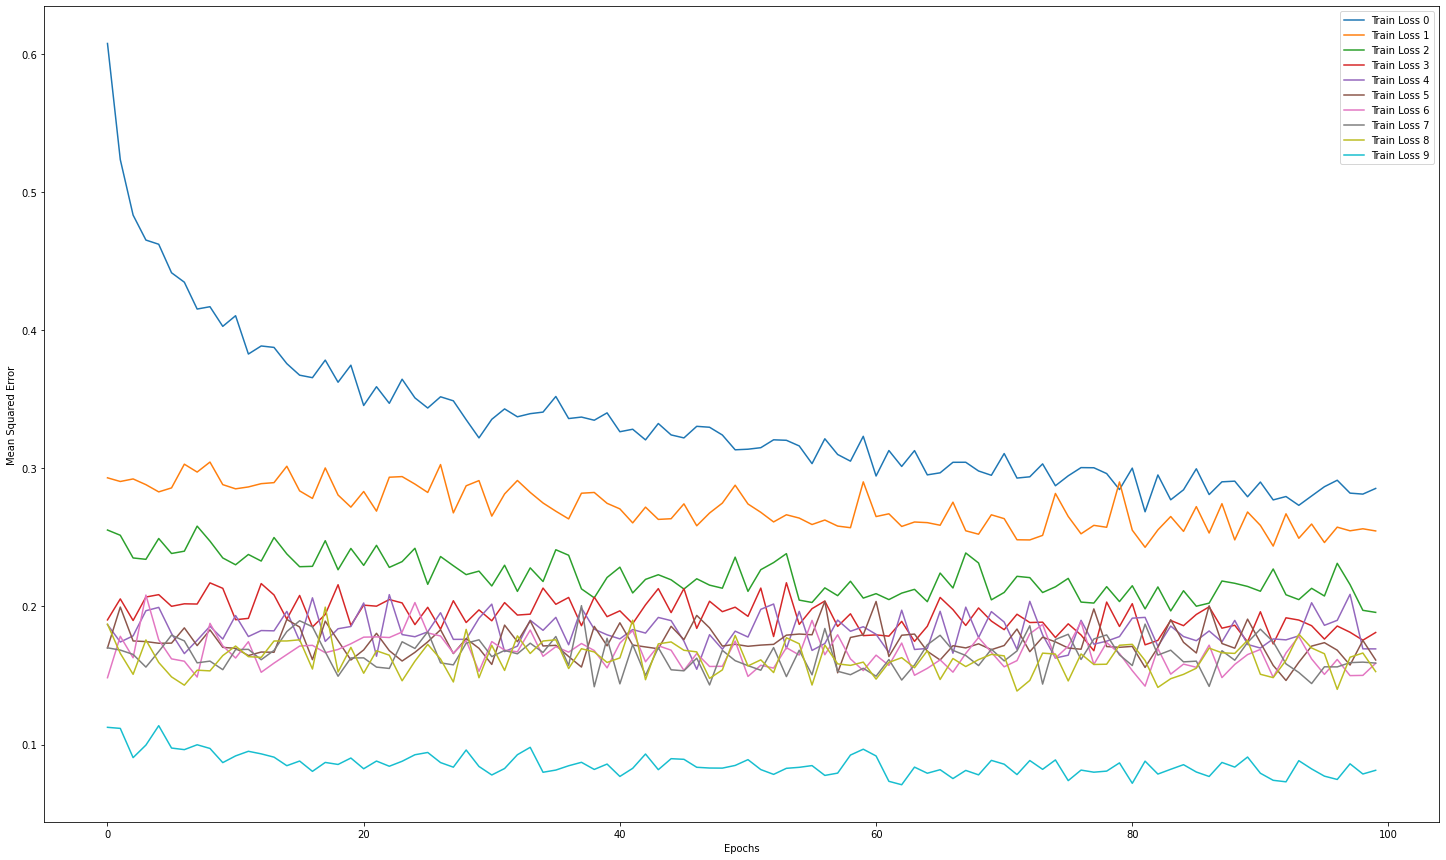

In [99]:
fig = plt.figure(figsize=(25, 15))

for idx, h in enumerate(history):  
  plt.plot(h.epoch, np.array(h.history['mean_squared_error']), label='Train Loss ' + str(idx))

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

### Evaluation

In [70]:
model = load_model('Cross_validation_model_1620511906.h5')

In [71]:
model.evaluate(X_test_scaled, y_test_scaled)

15/15 [==============================] - 0s 2ms/step - loss: 0.0360 - mean_squared_error: 0.0360


[0.035951368510723114, 0.035951368510723114]

In [72]:
y_pred = model.predict(X_test_scaled)
y_pred = pd.Series(map(lambda x: x[0], y_pred))
y_pred_inverse = ct_target.inverse_transform(y_pred)
 
y_test_inverse = pd.Series(map(lambda x: x[0], y_test_scaled))
y_test_inverse = ct_target.inverse_transform(y_test_inverse)
 
df_ads_pred = pd.DataFrame({ 'Actual': y_test_inverse, 'Predicted': y_pred_inverse }).astype('int64')
df_ads_pred['Error'] = abs(df_ads_pred['Actual'] - df_ads_pred['Predicted'])
df_ads_pred['%'] = (df_ads_pred['Error'] * 100 / df_ads_pred['Actual'])
 
df_ads_pred = df_ads_pred.sort_values(by=['%'])
 
print(str(int(round(df_ads_pred['Error'].mean()))) + '€')
print(str(int(round(df_ads_pred['Error'].median()))) + '€')
print(str(int(round(df_ads_pred['%'].mean()))) + '%')
print(str(int(round(df_ads_pred['%'].median()))) + '%')
 
print(str(int(round((df_ads_pred['%'] * df_ads_pred['Actual'].apply(lambda x: 1/x)).sum() / df_ads_pred['Actual'].apply(lambda x: 1/x).sum()))) + '%')
print(str(int(round((df_ads_pred['Error'] * df_ads_pred['Actual'].apply(lambda x: (1/x))).sum() / df_ads_pred['Actual'].apply(lambda x: (1/x)).sum()))) + '€')
 
print(str(int(round(df_ads_pred.loc[df_ads_pred['Actual'] < 1000000, 'Error'].mean()))) + '€')
print(str(int(round(df_ads_pred.loc[df_ads_pred['Actual'] < 1000000, '%'].mean()))) + '%')

38604€
19587€
9%
5%
11%
30746€
30889€
9%


MAE: 38604.08181039419
MSE: 5836697853.62975
RMSE: 76398.2843631305
VarScore: 0.9476550458273176


Text(0, 0.5, 'Predicted price [€]')

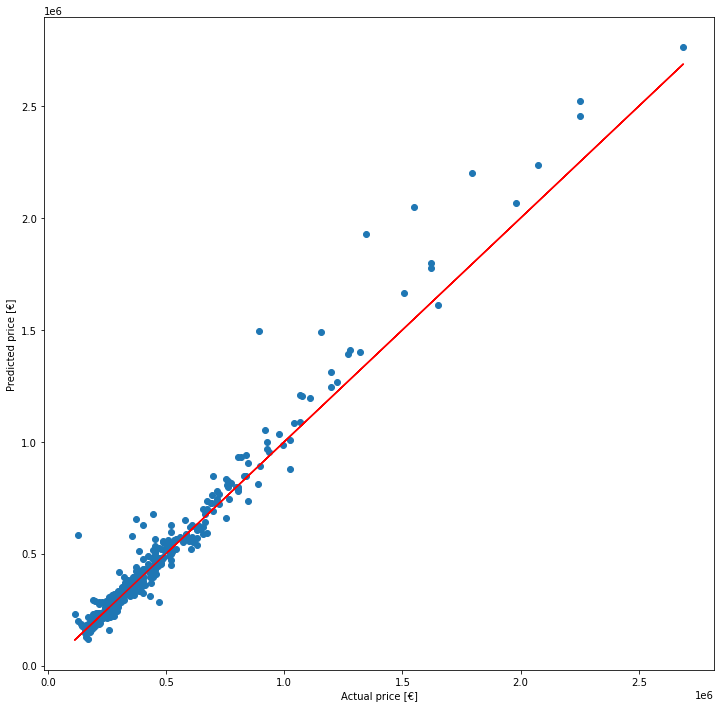

In [75]:
print('MAE:', metrics.mean_absolute_error(y_test_inverse, y_pred_inverse))
print('MSE:', metrics.mean_squared_error(y_test_inverse, y_pred_inverse))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_inverse, y_pred_inverse)))
print('VarScore:', metrics.explained_variance_score(y_test_inverse, y_pred_inverse))
 
plt.figure(figsize=(12, 12))
plt.scatter(y_test_inverse, y_pred_inverse)
 
plt.plot(y_test_inverse, y_test_inverse, 'r')
 
plt.xlabel('Actual price [€]')
plt.ylabel('Predicted price [€]')

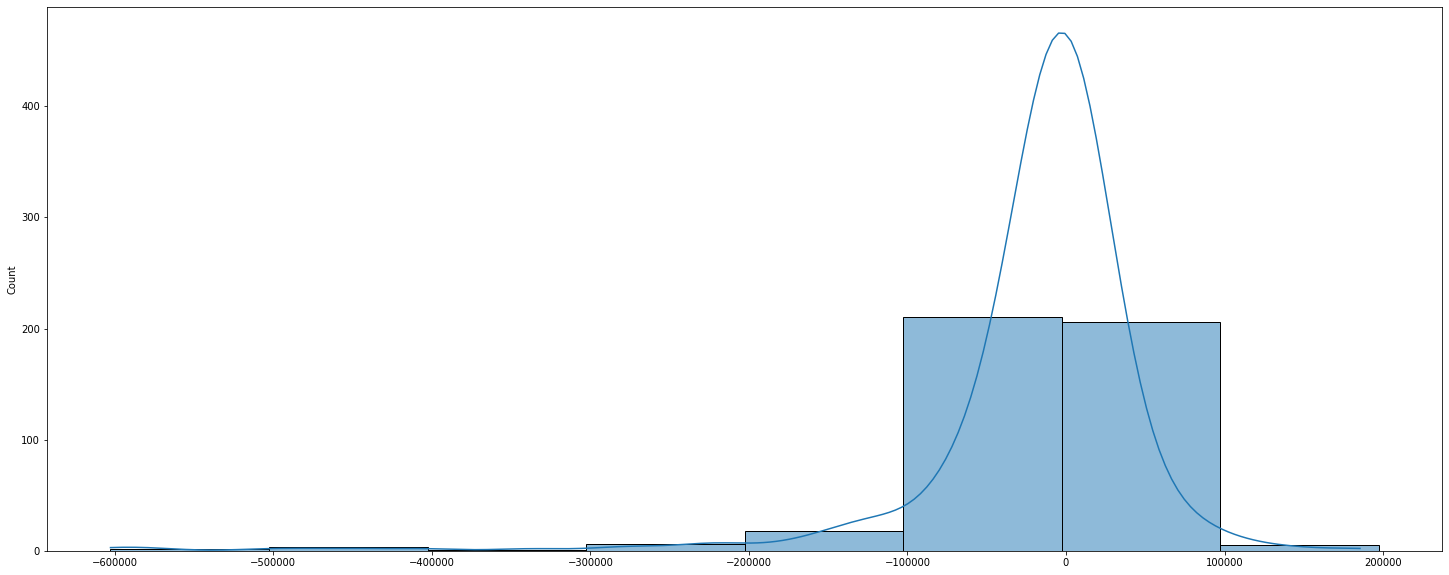

In [102]:
fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)
 
residuals = (y_test_inverse - y_pred_inverse)
sns.histplot(data=residuals, binwidth=100000, ax=ax, kde=True)

### Tensorboard

In [76]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
!zip -r /content/logs /content/logs

In [79]:
files.download("/content/logs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#tensorboard dev upload --logdir logs --name "Real Estate" --description "Housing Price Prediction in Milan (Italy) through Deep Learning via immobiliare.it.ipynb"

In [ ]:
https://tensorboard.dev/experiment/tGja2XRHQvebBPV4zw0yww/